# Práctica 2: clasificación de dígitos MNIST mediante AdaBoost 
ELVI MIHAI SABAU SABAU | 51254875L

# Introducción
En esta practica implementaremos un algoritmo adaboost, capaz de generar clasificadores fuertes para las diferentes clases de numeros (0 - 9).

De tal manera en la cual, usando dichos clasificadores fuertes, seremos capaces de clasificar numeros dada una foto en valores de grises de 28x28 pixeles.

Para ello, implementaremos dicho algoritmo, definiremos varias funciones para facilitarnos el trabajo, y analizaremos los resultados.

<hr>

Para ello, seguiremos los siguientes pasos:

* Primero, lo que haremos sera definir las funciones y el codigo que usaremos para ello, explicaremos las funciones mas importantes.

* Explicaremos adaboost, sus funciones asociadas, y la implementacion hecha.

* Explicaremos que contiene MNIST, Y como adaptaremos los conjuntos a usar.

* Despues analizaremos T, A, distribucion de entrenamiento / validacion, y puntos de clase / no clase **para un numero**, y su resultado.

* Analizaremos adaboost para N numeros, comprobando si los valores del analisis anterior nos sirven, o no, y su resultado.

* Explicaremos como combinar todos los clasificadores para cada clase, para cualquier tipo de numero, y lo implementaremos. Ademas de dejar un bloque de codigo de ejemplo para clasificar cualquier tipo de imagen.

* Probaremos definitivamente aplicandole a todos los clasificadores el conjunto de test.

* Y para finalizar, hablaremos un poco sobre lo que aporta dicho algoritmo, y conclusiones sobre ello.

<hr>

En este cuarderno, se detallara previamente a cada bloque de codigo, la descripcion y el funcionamiento de cada apartado.

# Funciones y Código general.

## Imports.

Primero, importamos las librerias que usaremos.

In [ ]:
import numpy as np                # Libreria para gestionar operaciones sobre vectores de manera extremadamente sencilla.
import matplotlib.pyplot as plt   # Libreria para hacer graficas.
import random                     # Libreria para generar numeros aleatorios (para los clasificadores debiles).
import math                       # Libreria para realizar funciones matematicas ( en concreto floor que es la que usaremos )
import time                       # Libreria para calcular el tiempo transcurrido.
import cv2                        # Libreria para gestionar imágenes propias.

from keras.datasets import mnist  # Dataset de MNIST.
from tqdm import tqdm             # Libreria para mostrar una barra de progreso en los bucles.
from skimage import io            # Libreria para cargar imágenes desde internet.

Desde la libería de Keras podemos descargar la base datos MNIST




In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape,y_train.shape


((60000, 28, 28), (60000,))

## Funciones auxiliares básicas.

Funcion para representar los clasificadores fuertes obtenidos en una grafica, en la cual Y es el numero de pixel, y X el error.

In [ ]:
# Funcion para imprimir graficas rapidamente
def plot_arrays(X, Y, title, xlabel, ylabel):
    plt.figure(1)
    plt.title(title)
    plt.plot(X, Y, "bo")
    plt.xlabel(ylabel)
    plt.ylabel(xlabel)
    plt.show()

Funcion que carga una imágen desde una url, la redimensiona a 28 * 28 con un metodo a elegir de cv2, y devuelve el array del canal de color especificado.
( Red: 0, Green: 1, Blue: 2 ).

Los métodos de redimension usan algoritmos de repoblación del color de los pixeles.

Desde la documentación:

```
NTER_NEAREST - a nearest-neighbor interpolation
INTER_LINEAR - a bilinear interpolation (used by default)
INTER_AREA - resampling using pixel area relation.
INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood
```

In [ ]:
def cargar_imagen(url, metodo, canal):
  # Primero, la cargamos en una variable local.
  num = io.imread(url)

  # Despues reducimos la dimension a 28 * 28.
  numRes = cv2.resize(num, (28, 28), interpolation=metodo)

  # Despues la pasamos a un array de numpy, obteniendo solo un canal de color, el azul ( Red, Green, Blue ).
  x = numRes[:,:,canal]

  return x

## Variables globales.


Deshabilitar los prints de todas las funciones, para que no se llenen las salidas.


In [ ]:
globalprint = False

Variable que alberga las salidas de funciones que no queremos usar pero tampoco queremos que se muestren por consola.

In [ ]:
dump = []

## Funciones auxiliares importantes.


Esta función, devuelve 2 vectores `(XA, YA)`, uno de imágenes y otro de 1s o -1s.

El primer vector `XA` es un vector de imágenes adaptado a una clase, esto significa que el `porcentaje_clase` recibido será el % de imágenes de la clase que contiene `XA`, y el resto serán imágenes de otras clases.

Además con los valores `E` y `S` se puede seleccionar un subvector del total de imágenes de la clase, que `XA` contendrá ( esto sirve para configurar que imágenes de la clase se quieren, asi evitando repetirlas, esto se usa por ejemplo para generar el conjunto de entrenamiento y de validacion, con fotos de la clase, pero sin repetirlas en ambos ).

`E` y `S` en conjunto con `porcentaje_clase`, se pueden usar para configurar cuantas imágenes se quieren en total.

<br>

Internamente, la funcion obtiene un vector `arr_clase` de todas las imagenes de la clase pasada por parametro (esto se hace usando una mascara con `numpy`), y obtiene un subvector aparte desde la posicion `S` a la posicion `E` de `arr_clase`.

Calcula el numero de imágenes que no son de la clase clase a concatenar dependiendo del `procentaje_clase`, el `S` y `E` introducidos, llamaremos a este valor `E_complementario`.

A dicho subvector seccionado que ahora llamaremos `XA`, se le concatena las imágenes restante de otro vector de imágenes que no son de la misma clase (`arr_noClase`), ese vector se genera usando la mascara negada que usamos para generar arr_clase.

Y con esto ya tendriamos `XA`.

<br>

Dependiendo del `porcentaje_clase` que se haya pasado, `XA` tendrá una cantidad especifica de imágenes que no son de la clase, por ejemplo:

si se pasara `0.4` como `procentaje_clase`, del total de imágenes de `XA`, el 40% de `XA` serán imagenes de la clase, y el otro 60% imagenes que no son de la clase.

<br>

La `YA` a devolver es un vector que contiene 1 en las posiciones donde en la misma posición en `XA` hay una foto de la clase a adaptar, y un -1 en el resto de posiciones.

Devolviendo un `XA` e `YA` adaptado.



In [ ]:
# El conjunto de entrenamiento para una clase ( tipo de imágen ).
def adaptar_conjunto_entrenamiento(S, E, porcentaje_clase, clase, X, Y):

  # Creamos una máscara para todo el conjunto puntos X usando Y
  mask = Y == clase

  # Partimos en 2 el dataset de que se nos ha pasado X, en los elementos que son de la clase, y los que no lo son  arr_clase = X[mask]
  arr_clase = X[mask]
  arr_noClase = X[~mask]

  """ 
  Calculo de la cantidad de puntos de noClase para complementar el porcentaje del conjunto a devolver, por ejemplo,
    si tenemos 8 imágnes en total de la clase, y queremos que de la clase haya un 80% de imágenes, el otro 20% (20 imagenes) debe ser de noClase
    para esto, se realiza este calculo, se calcula la cantidad de imágenes de noClase que se quiere añadir al conjunto adaptado.
  """
  E_complementario = math.floor((E-S) / porcentaje_clase - (E-S))

  if globalprint :
    print("---------------------- ADAPTADOR DE CONJUNTOS ----------------------")
    print("| Num. total de numeros de la clase: " + str(len(arr_clase)))
    print("| Num. total de numeros de la !clase: " + str(len(arr_noClase)))
    print("| Pos. inicio introducido: " + str(S))
    print("| Pos. final introducido: " + str(E))
    print("|-------------------------------------------------------------------")
    print("| Porcentaje de puntos de la Clase: " + str(porcentaje_clase * 100) + "% (" + str((E-S)) + ").")
    print("| Porcentaje complementario de noClase: " + str(100 - porcentaje_clase * 100) + "% (" + str(E_complementario) + ").")
    
  # Comprobamos valores.
  if(E-S > len(arr_clase)):
    raise Exception('No hay suficientes puntos de la clase.')

  if(E_complementario > len(arr_noClase)):
    raise Exception("No hay suficientes puntos de noClase para complementar dicha fraccion.")

  # Mezclamos el arrray de arr_noClase, para que no tenga el mismo orden en otras llamadas.
  np.random.shuffle(arr_noClase)

  # Concatenamos dichos arrays de imagenes, y aparte creamos Y, un array de 1 y -1 por cada posicion de X dependiendo de su imagen.
  XA = np.concatenate((arr_clase[S:E], arr_noClase[0:E_complementario]))
  YA = np.concatenate((np.ones(E-S), np.ones(E_complementario) * -1))
  
  if globalprint :
    print("--------------------------------------------------------------------")
    print("| El tamaño del conjunto es de: " + str(len(XA)))
    print("| Len de X e Y: " + str(len(XA)) + ", " + str(len(YA)))
    print("--------------------------------------------------------------------")

  return (XA, YA)

Esta funcion devuelve un breve analisis del resutlado de la ejecucion de adaboost para una clase, para unos T, A, Distribuciones de Entrenamiento / Validacion y Imagenes de clase / Imagenes que no son de la clase, basados en unos `X` e `Y`, pasados por parametro.

<br>

La funcion obtiene usando numpy un array de todas las imagenes de una clase, y el numero total de estos.

Calcula la cantidad de imagenes que deberia tener el conjunto de entrenamiento y validacion dado un % de distribucion de los conjuntos, y otro % de distribucion de imagenes de clase / noClase, llamando a `daptar_conjunto_entrenamiento` con unos `S` y `E` especificos previamente calculados para cada conjunto.

<br>

Por ejemplo: si hay 1000 imagenes de la clase a analizar, y `porcentaje_conjunto` es 0.8, el `S` y `E` con el que se llamara `adaptar_conjunto_entrenamiento` para generar el conjunto de entrenamiento sera `0` y `799`.

Y el `S` y `E` con el que se llamara a `adaptar_conjunto_entrenamiento` para generar el conjunto de validacion sera `800` y `999`, ademas de a ambas llamadas a `adaptar_conjunto_entrenamiento` se le pasa el % de `porcentaje_clase` obtenido por parametro.

<br>


Una vez generados dichos conjuntos con estos parametros, se llama a adaboost con el `T`, `A` obtenidos por parametro, y `X` e `Y` generados anteriormente.

Y despues se obtiene los resultados de pasarle al clasificador fuerte: las imagenes del conjunto con el que ha entrenado, el conjunto de validacion, y todo el conjunto de `x_train`, y muestra una grafica basada en dichos resultados.

In [ ]:
# Funcion para aplicar el clasificador fuerte a un set de entrenamiento & validación adaptados, el conjunto entero de entrenamiento y, devolver sus % de error, y mostrar una gráfica de los resultados.
def analizar(T, A, clase, porcentaje_cojunto, porcentaje_clase, X, Y):

  # arrays de imágenes de solo la clase
  arr_Clase = Y[Y == clase]

  # logitud de dichos arrays.
  lenArr_Clase = len(arr_Clase) - 1
  
  if globalprint :
    print("----------------------------- ANALIZAR -----------------------------")
    print("| Numero de imágenes de la clase en total: " + str(lenArr_Clase))

  # Cantidad de puntos para el conjunto de entrenamiento.
  # La cantidad de puntos para el conjunto de validación es lenArr_Clase - cantPuntosEntrenamiento (la parte restante)
  cantPuntosEntrenamiento = math.floor(lenArr_Clase * porcentaje_cojunto)

  if globalprint :
    print("| Cant. de puntos en el conjunto de entranmeinto adaptado: " + str(cantPuntosEntrenamiento))
    print("| Cant. de puntos en el conjunto de validación adaptado: " + str(math.floor(lenArr_Clase - cantPuntosEntrenamiento)))
    print("--------------------------------------------------------------------")


  # Adaptamos los conjuntos de entrenamiento y validación, los % de imágenes de clase que querramos, ambos conjuntos tendrán el mismo % de imágenes de clase y noClase.
  # Con. entrenmaiento.
  (xtrinen, ytrinen) = adaptar_conjunto_entrenamiento(0, cantPuntosEntrenamiento, porcentaje_clase, clase, X, Y)
  # Normalizamos las imágenes, de 28 * 28 a un array unidimensional.
  xtrinen = xtrinen.reshape(len(xtrinen), 28 * 28)

  # Lanzamos el entrenamiento con el conjunto de entrenamiento particionado adaptado.
  start = time.time()
  H = adaboost(xtrinen, ytrinen, T, A)
  end = time.time()
  tiempo_total = end - start
  
  if globalprint :
    print("| Tiempo gastado entrenando en segundos: " + str(tiempo_total))
  
  # Con. Validacion.
  (xtrinva, ytrinva) = adaptar_conjunto_entrenamiento(cantPuntosEntrenamiento, lenArr_Clase, porcentaje_clase, clase, X, Y)
  xtrinva = xtrinva.reshape(len(xtrinva), 28 * 28)


  # Probamos el clasificador.
  if globalprint :
    print("| Procesando el conjunto de entrenamiento adaptado.")
  
  TRINEN = probar_clasificador_fuerte(xtrinen, ytrinen, H)
  
  if globalprint :
    print("| Procesando el conjunto de validación adaptado.")
  
  TRINVA = probar_clasificador_fuerte(xtrinva, ytrinva, H)

  # Probamso el clasificador con todo train.
  X = X.reshape(len(X), 28 * 28)
  Y = y_train
  Y = np.int64(Y == clase)
  Y[np.where(Y == 0)] = -1
  
  if globalprint :
    print("| Procesando el conjunto de entrenamiento entero.")
  
  TRINTR = probar_clasificador_fuerte(X, Y, H)


  # Mostramos la gráfica bien chula y de tallada.
  descripcion = '\n'.join(("Con T: " + str(T) + " y A: " + str(A) + " se ha generado, entrenado y probado un clasificador fuerte para la clase: " + str(clase) + " .",
                           "De un total de " + str(math.floor(lenArr_Clase + lenArr_Clase * porcentaje_clase)) + " puntos ( combinacion de clase y noClase ), se ha usado un " + str(porcentaje_cojunto * 100) + " % para el conjunto de Entrenamiento, y el " + str(100 - porcentaje_cojunto * 100) + " % restante para el conjunto de Validación.",
                           "La distribución que se ha usado de puntos de clase / noClase en los conjuntos de Entrenamiento y Validación es de: "  + str(porcentaje_clase * 100) + " % puntos de la clase y " + str(100 - porcentaje_clase * 100) + " % puntos que no son de la clase."))
  fig = plt.figure(2)
  ax = fig.add_axes([0,0,1,1])
  
  ax.set_title("Precisiones alcanzadas en un tiempo total de: " + str(np.fix(tiempo_total)) + " segundos, con T: " + str(T) + " y A: " + str(A) + ".")
  
  ax.bar(1, TRINEN, label = "Precision con el conjunto de Entrenamiento adaptado.", data = TRINEN, color = "blue")
  ax.bar(2, TRINVA, label = "Precision con el conjunto de Validacion adaptado.", data = TRINVA, color = "red")
  ax.bar(3, TRINTR, label = "Precision con TODO el conjunto de entrenamiento (x_train).", data = TRINTR, color = "orange")

  props = dict(boxstyle='round', facecolor='white', alpha=0.5)


  ax.text(1.05, 0.8, descripcion, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=props)
  ax.set_xticks([1,2,3])
  ax.set_xticklabels([str(TRINEN) + " %", str(TRINVA) + " %", str(TRINTR) + " %"])
  ax.legend(loc='center left', bbox_to_anchor=(1.03, 0.5), fontsize=11)

  # Devolvemos el clasificador, y sus errores por si los queremos usar en otro sitio.
  return [H, TRINTR, TRINEN, TRINVA]



## Funciones de aplicación de clasificadores fuertes.


Definimos una funcion para aplicar un clasificador fuerte a un conjunto de imágnes.

Devuelve 1 o -1 si el resultado de la clasificación es que la imágen es de la clase.

Se calcula comprobando cada clasificador debil por todas las imágenes, y multiplicando su confianza por el resultado de este, devolviendonos su certeza.

El resultado siendo un array de valores, cada posición correspondiende al resultado de la clasificación del clasificador debil por Xi imágen.

Como este proceso se hace por cada clasificador, se suman los vectores resultantes htY, y se devuelve un array de signos en formato 1 o -1, dependiendo de su signo, siendo este el resultado de la clasificación de todos los clasificadores debiles por cada imágen.

In [ ]:
def aplicar_clasificador_fuerte(H, X):  
  certeza = []

  # Por cada clasificador debil ht del cojunto de fuertes H, lo aplicamos a todas las imágenes de X.
  for [ht, alpha] in H:

    # POR CADA IMAGEN SE PASA TODAS LAS ht
    resultados = aplicar_clasificador_debil(ht, X)

    if (len(certeza) == 0):
      certeza = alpha * resultados
    else:
      # Esta suma es una suma horizontal de vectores con numpy, cada posición del primer vector se suma con la misma posición del otro vector.
      certeza = certeza + (alpha * resultados)

  # Devuelve un array de len(X), siendo cada posición el resultado de la clasficiación de cada imágen.
  f = np.int64(np.sign(certeza))
  
  return f

Y otra funcion para obtener el error de clasificar un conjunto de imágenes por un clasificador fuerte.

El valor devuelto es la precisión ( % de acierto ), esto se calcula sumando el numero de clasificaciones fallidas, y este dividido por el numero total de imágenes.

Los fallos se calculan como: `num_fallos = np.sum(Y != htY)` obteniendo un array donde hay 1s en la posición fallada, y 0s, en la posición fallada, y sumando todas las posiciones del array resultante.

In [ ]:
def probar_clasificador_fuerte(X, Y, H):
  
  if globalprint :
    print("---------------- APLICAR Y CALCULAR ERROR H ------------------------")

  # comparamos entre los numeros detectaodos, y la Y adaptada a la clase,
  numeros_detectados = aplicar_clasificador_fuerte(H, X)

  # Suma vertical de todas las posiciones del array.
  numero_fallos = int(np.sum(np.int16(Y != numeros_detectados)))

  # Obtenemos el % de error
  error = (numero_fallos / len(Y)) * 100

  # Obtenemos el % de precisión.
  precision = 100 - error
  
  # Metemos un intro vacio.
  print()

  # Mostramos el resultado por consola.
  if globalprint :
    print("| Numero total de fallos: " + str(numero_fallos) + ", Numeros total de imágenes: " + str(len(X)))
    print("| Precision: " + str(precision) + " %")
    print("| Error: " + str(error) + " %")
    # print("| Resultados: " + str(list(zip(numeros_detectados, np.int64(Y)))))
    print("--------------------------------------------------------------------")
  
  # Devolvemos la precisión.
  return precision

Y para acabar, una funcion que nos permite aplicar un clasificador fuerte a una imágen sola.

In [ ]:
def aplicar_clasificador_fuerte_individual(H, x, print_num = False):

  if print_num:
    # Imprimimos la imágen.
    plt.imshow(x)
    plt.show()

  # Adaptamos la imágen.
  X = np.array([x])
  X = X.reshape(len(X), 28 * 28)
  
  # Obtenemos el resultado de la clasifición.
  resultado = aplicar_clasificador_fuerte(H, X)[-1]

  # Decimos si es de la clase o no.
  if globalprint :
    if (resultado == 1):
      print("\nLa imágen es de la misma clase que el clasificador fuerte!")
    else:
      print("\nLa imágen no es de la misma clase que el clasificador fuerte!")

  # devolvemos el resultado ( 1 o -1 ).
  return resultado

## Funciones de clasificación final ( Solución Adaboost ).

Y esta función es la solución de adaboost, una funcion que usa de todos los clasificadores fuertes para clasificar cada numero individualmente, y devolver que numero es.

La funcion prueba cada clasificador, en caso de que haya más de uno que coincida ( devuelva 1 para una imágen ), se seleccionará el que mayor % de precisión haya tenido en Validación.

In [ ]:
def clasificar_individual(HTARR, x, print_mensaje = True, imshow_num = False):
  numero = -1
  prec = 0

  if imshow_num:
    # Imprimimos la imágen.
    plt.imshow(x)
    plt.show()

  for i in range(len(HTARR)):
    classificado = aplicar_clasificador_fuerte_individual(HTARR[i][0], x, False)

    # Si el clasificador clasifica el numero como que es de su clase, y es el que mayor precisiontiene
    if (classificado != -1 and prec < HTARR[i][3]):
      numero = i
      prec = HTARR[i][3]

  # Decimos de que clase es la imágen
  if print_mensaje:
    if numero != -1:
      print("\nLa imágen es un " + str(numero))
    else:
      print("\nLa imágen no es un numero.")
      
  
  return numero


Funcion que clasifica un conjunto de numeros.

Recibe un array de imágenes, y devuelve un array de numeros HTY con el valor correspondiente de la clase clasificada para cada numero.

In [ ]:
def clasificar_conjunto(HTARR, X, print_mensaje = False):
  HTY = []

  for x in tqdm(X):
    HTY.append(clasificar_individual(HTARR, x, print_mensaje))

  return np.array(HTY)

# Adaboost

## Explicacion de Adaboost.

### Introduccion.


Adaboost es un algoritmo que nos permite decidir de maner automática si un dato pertenece a una clase dependiendo de las caracteristicas de dicho dato.

Adaboost es un algoritmo clasificador binario, lo que significa que solo nos podrá decir sin un dato pertenece a la clase para la que ha entrenado o no.


### Clasificador debil y fuerte.

Para poder clasificar diferentes tipos de datos, deberemos entrenar adaboost para cada tipo de clase de datos.

En el programa implementado, no se entrena adaboost como tal, sino, que adaboost nos devuelve un conjunto de valores que podemos usar para identificar si un dato ( que puede ser una imágen, una fracción de una banda sonora, o otro tipo de dato ) coincide con ciertos patrones que se asemejan al conjunto de valores devuelto por adaboost.

Dicho conjunto de valores que nos devuelve adaboost se llama **Clasificador Fuerte**, y está formado por muchos **Clasificadores Debiles** que sirven para identificar una caracteristica del tipo de datos a identificar.


### Como se generan los clasificadores?


El clasificador fuerte se forma de los clasificadores debiles que menos han fallado al comprobarse con el conjunto de datos recibido para entrenar, de esta manera el clasificador fuerte contiene clasificadores debiles que tienen un % de error un poco superior al 50% al clasificar datos de la misma clase.

### Funcionamiento.

Ya que nuestra práctica se basa en identificar imágenes con un unico canal de color, las carácteristicas que nosotros usaremos es el valor de los pixeles, identificando si el valor de un pixel en concreto supera cierto valor de color o no.


Es así como generaremos nuestros calsificadores debiles, cada uno de los clasificadores debile serán arrays de 3 posiciones, que contendrán:
* \[0]: el numero de pixel.
* \[1]: el valor del pixel.
* \[2]: el umbral del pixel a comparar, si es 1, se compara si esta por encima que el valor del pixel, y si es 0 si está por debajo.

De esta manera, nosotros podremos comparar cada clasificador debil con una imágen, por ejemplo, si nuestro clasificador debil `ht` tiene los siguientes valores:

```Python
[0] = 5
[1] = 150
[2] = 0
```

Tendremos que verificar si la imágen recibida, el valor el pixel numero 5 es inferior o igual a 150.

### Datos de entrenamiento, y comprobación.

Dichos valores de nuestro clasificador debil se generarán de manera aleatoria, y escogeremos solo aquellos que mejor se adecuen a las imágenes de la clase a entrenar.

Esto se hace usando otro conjunto de datos que contienen el resultado real del dato a clasificar, siendo `X` el conjunto a clasificar de datos ( en este caso de imágenes ), y `Y` el conjunto de datos que posee las etiquetas de `X`, con el cual comprobar si un clasificador debil está en lo correcto o no. Como adaboost es un clasificador binario, deberemos adaptar `Y` de tal manera que, en las posiciones que contenga la clase a clasificar, en vez que tener la etiqueda de dicha clase, tendrá un `1`, y en caso contrario un `-1`.



### Aplicación.

Hasta ahora hemos dicho que los clasificadores fuertes son un conjunto de ckasufucadores debiles que albergan caracteristicas que se encuentran en las imágenes de una clase, pero realmente, ¿como entrenas dichos clasificadores debiles?

Nuestro algoritmo adaboost posee un vector de valores llamado D, del mismo tamañi que X.

D contiene unos valores que definen lo dificil que está siendo para los clasificadores debiles clasificar una imágen.

Cada posición de D hace referencia a una imágen, y su valor es la complegidad de clasificar dicha imágen, si un clasificador debil clasifica erroneamente una imágen, se le suma a su error el valor de D que hay en la misma posicion que tiene dicha imágen en X.

La suma de los errores es el error final de dicho clasificador debil.

Esto da lugar al siguiente proceso:

| imagen |  1  |  2  |  3  |  4  |
|:------:|:---:|:---:|:---:|:---:|
|   ht   |  1  |  1  |  0  |  1  |
|    Y   |  1  |  0  |  1  |  1  |
|    D   | 0.2 | 0.4 | 0.2 | 0.2 |

Siendo el resultado del vector de errores, la multiplicación de 0 \* Di si el resultado es el correcto, o la multiplicación de 1 \* Di de lo contrario.

| errvec |  0  | 0.4 | 0.2 |  0  |
|:------:|:---:|:---:|:---:|:---:|

Y el error de dicho ht se calcula como la suma de todos los valores de D, usando el ejemplo anterior, el error seria 0.6 .

<br>

Por cada clasificador debil probado, se equilibra D, mientras más clasificadores debiles fallen en una imágen en concreto, el valor en D de la misma posicion de la imágen en X aumenta.

Un alto valor en D significa que dicha imágen en X es compleja de clasificar, y viceversa, de tal manera que, si encontramos un clasificador debil que no falle en una imágen con un valor D alto, dicho clasificador tendrá un bajo error.

De dicho D, y del error acumulado de cada clasificador, se obtiene su confianza, que es un valor de lo fiable que es dicho clasficador.

<br>

Pero.. como se aplica un clasificador fuerte a una imágen individualmente para saber si es de la clase entrenada o no?

Esto se hace multiplicando las confianzas de cada clasificador debil por su decisión (1 si el dato es de la clase, y -1 si no lo es), sumando el resultado de todos los clasificadores debiles, y devolviendo su signo, el signo siendo si la mayoria de dichos clasificadores debiles deciden que la imágen pasada es de la clase o no, y la confianza siendo el peso / fiabilidad que tiene cada clasificador, esto se calcular internamente en adaboost con una formula, calculando su tasa de error, y la tasa de acierto usando D.

### Cuantos clasificadores, y cuantas imágenes necesito?

En adaboost, la variable `T` especifica el total de clasificadores debiles que un clasificador fuerte tendrá, de todas formas, no nos quedaremos con los primero en generar, sino que generaremos `A` clasificadores debiles, y nos quedaremos con el que tenga el menor error.

Como hemos visto, un clasificador debil no nos sirve de mucho, ya que aunque el resultado esté en lo correcto, es muy probable que no nos sirvan para diferentes fotos de la misma clase, teniendo un alto % de error al clasificar, pero la agrupación de varios nos sirve identificar el patrón que sigue las imágenes de la clase a clasificar.

También, un alto numero de clasificadores debiles podrian inportunarnos, haciendo el entrenamiento excesivamente lento, e incluso llegando al punto de sobreentrenar el clasificador fuerte, haciendo que el patrón resultante solo nos sirva para identificar imágenes del conjunto que se ha usado para el entrenamiento, y falle en un % alto al comprobar imágenes de la misma clase que no estén en el conjunto de entrenamiento.

<br>

Y más de lo mismo para las imágenes, pocas imágenes no crearán un patrón correcto, y muchas es probable que encuentre caracteristicas de rasgos comunes entre el resto de clases...

<br>

Así que al fin y al cabo, es probar, y ver que valor es el mejor para cada clase. Este apartado se detalla más en el apartado de MNIST.

### Conclusion.



Una vez obtenido el conjunto de clasificadores debiles, se compactan con su confianza, y se devuelven, siendo este el clasificador fuerte que devolverá nuestra funcion de `adaboost`.

<br>

En nuestra práctica, como las clases a clasificar son fotos de numeros del 0 al 9, deberemos entrenar 10 clasificadores fuertes, uno por cada numero, de tal manera que cuando querramos saber que numero hay en una foto, deberemos pasarle todos los clasificadores fuertes, y el que nos devuelva 1 será el clasificador entrenado para dicho numero, en caso de que hayan varios clasificadores que devuelvan 1, como por ejemplo para los numeros 8 y 6, que son bastante similares, escogeremos el que mayor % de precisión tenga.

## Implementacion de adaboost.

### Métodos auxiliares.

Funcion que genera un clasificador debil (array de 3 posiciones, basado en valores aleatorios).

In [ ]:
# dim: Dimensión con la que vamos a trabajar. En nuestro caso 28*28
def generar_clasificador_debil(dim_imagen):
  ht = np.zeros(3)
  ht[0] = np.random.randint(0, dim_imagen)     # Num. Pixel
  ht[1] = random.randint(0, 255)               # Valor Umbral Grises
  ht[2] = np.sign(np.random.rand(1) * 2-1)     # Valor del ubral, miramos por encima (1) o por debajo (-1).
  return ht;

Funcion que aplicara un clasificador debil ht a un array de imagenes, se comprobara para cada imagen de X, si el valor del pixel de la imagen esta por encima o por debajo / igual que el valor del clasificador, dependiendo del valor del umbral del clasificador.

In [ ]:
def aplicar_clasificador_debil(ht, X):

  # Por cada imágen de X, comprobamos si el pixel de dicha imágen tiene un valor mayor o menor que el clasificador
  if(ht[2] == 1):
    mascara_resultados = X[:, int(ht[0])] > ht[1]
  else:
    mascara_resultados = X[:, int(ht[0])] <= ht[1]

  # Usamos int para pasar de true y false a 1 y 0
  resultados = np.int16(mascara_resultados)
  
  # Pasamos de 0 a -1
  resultados[np.where(resultados == 0)] = -1

  return resultados

Obtenemos el error de los resultados de comprobar X para un clasficador debil, sumando el valor de cada posición D al error, de las posiciones en las cual ha fallado la clasificación.

In [ ]:
# El error es la suma total de la posibilidad de fallar en una imágen, por todas las imágenes que ha fallado.
def obtener_error(resultados, Y, D):

  # -1 si no es, 1 si es, y con int64 pasamos los true y falses resultantes a 1 y 0
  errv = np.int64(resultados != Y)
  
  # Si errv[i] == 0, al multiplicar el error por 0 da 0, y si multiplicamos el error por 1, es el error, entonces, sumerr es la suma de la probabilidad de fallar en una imágen de todas las imágenes en las que ha fallado.
  sumerr = np.float64(np.sum(errv * D))
  
  return [sumerr, errv]

### Función adaboost.

Nuestro preciado algoritmo adaboost supercurrado.

Este algoritmo recibe 2 vectores X e Y ( X: imágenes adaptadas unidimensionales, Y: etiquetas adaptadas a 1 y -1 dependiendo si son de la clase o no ) y 2 valores numericos T y A (T: Cantidad e clasificadores debiles que compondran un clasificador fuerte, A: Cantidad de clasificadores debiles a probar para extraer el mejor de ellos. ).
 

In [ ]:
def adaboost(X, Y, T, A):
  print("-------------------------- ⭐ ADA BOOST ⭐ ------------------------")
  
  # Vector de probailidad de fallar al reconocer una imágen, se actualiza por cada clasificador debil, inicialmente uniforme.
  D = np.ones(len(X), dtype=np.double) / len(X)

  # Datos para la gráfica.
  pixel = []
  error = []
  
  # Array donde guardaremos tuplas de [mejor_clasificador, confianza] = [ht, alpha]
  H = []

  print("| Entrenando...")
  
  for t in tqdm(range(T)):
    
    # Menor suma de array de errores * D del clasificador debil y su array de errores.
    menor_sumerr = np.inf
    menor_errv = []

    # Mejor clasificador debil ( de A pruebas aleatorias, el que menor error tiene ).
    mejor_ht = None

    # Probamos A clasificadores debiles, y nos quedamos con el mejor de todos.
    for k in range(A):

      # Generamos un clasificador debil con valores aleatorios, pasamos el total de pixeles por parámetro.
      ht = generar_clasificador_debil(28 * 28)

      # Aplicamos el clasificador debil a todas las imágenes, obtenemos el resultado.
      resultado = aplicar_clasificador_debil(ht, X)

      # Obtenemos el error de dicho clasificador, para cada imágen, calculado sobre D.
      [sumerr, errv] = obtener_error(resultado, Y, D)
      
      # Filtramos el ht con menor error.
      if(sumerr < menor_sumerr):
        mejor_ht = ht
        menor_sumerr = sumerr
        menor_errv = errv

    # Calculamos la confianza.
    alpha = np.float64(0.5 * np.log2((1.0 - menor_sumerr) / menor_sumerr))

    # Arrays de clasificadores y sus confianzas.
    H.append([mejor_ht, alpha])

    # Recalculamos D y normalizamos.
    # print((alpha, menor_sumerr, np.sum(D)))
    Z = np.sum(D)
    exp = np.float64(np.exp(-alpha * -np.float64(menor_errv)))
    D = np.float64((D * exp) / Z)

    # Datos para gráfica.
    pixel.append(mejor_ht[0])
    error.append(menor_sumerr)



  # Un plot chulo de los clasificadores debiles que componen el fuerte a devolver (H)
  plot_arrays(error, pixel, "Grado de Error - 1: 100% error, 0: Perfecto.", "Numero de Pixel.", "Error de cada Clasificador por Pixel")

  return (H)


## Prueba básica de adaboost.

A continuación haremos una prueba del funcionamiento de Adaboost.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


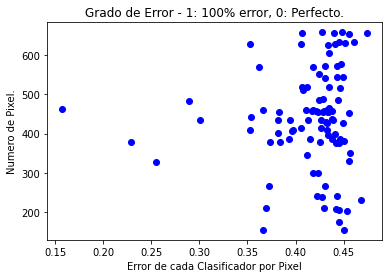

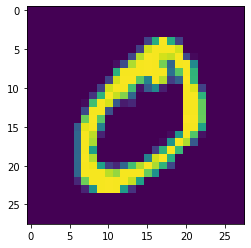


La imágen es de la misma clase que el clasificador fuerte!


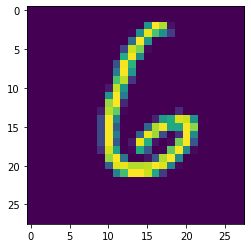


La imágen no es de la misma clase que el clasificador fuerte!


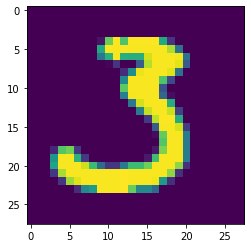


La imágen no es de la misma clase que el clasificador fuerte!


In [ ]:
# Clase de dato a clasficar ( tipo de número ).
clase = 0

# X = Array de N imágenes.
# Y = Array de tags relacionados con cada imágen, adaptada a la clase (1 y -1s).
(X, Y) = adaptar_conjunto_entrenamiento(0, 1000, 0.7, clase, x_train, y_train)

# Pasamos x de un array bidimensional de 28 * 28 a uno unidimensional.
X = X.reshape(len(X), 28 * 28)

# Cantidad de clasificadores debiles a probar para extraer el mejor de ellos y añadirlo al clasificador fuerte.
A = 500

# Cantidad e clasificadores debiles que compondran un clasificador fuerte.
T = 100

# adaboost devolviendo un clasificador fuerte para H0
H0 = adaboost(X, Y, T, A)

# Habilitamos que las funciones puedan mostrar mensajes por salida.
globalprint = True

# Vamos a clasfiicar imágenes random de x_train.
aplicar_clasificador_fuerte_individual(H0, x_train[1], True)
aplicar_clasificador_fuerte_individual(H0, x_train[32], True)
aplicar_clasificador_fuerte_individual(H0, x_train[4101], True)

# Deshabilitamos que las funciones puedan mostrar mensajes por salida.
globalprint = False

# El conjunto MNIST



## Que contiene y para que lo usaremos.


En este apartado hablaremos son el dataset, y los conjuntos que se usarán y  como se generaran.

<br>

MNIST nos devuelven 4 vectores ( 2 cojuntos de X e Y ), `x_train`, `y_train`, `x_test`, y `y_test`.

Los conjuntos `x_train` e `y_train` son mezclas de imágenes del 0 al 9, y su array de etiquetas correspondiende, hay en total 60k ( 60000 ).

Este conjunto se usa para entrenar adaboost, nosotros trabajaremos principalemtne sobre este conjunto.

El conjunto de `x_test` e `y_test` son lo mismo, pero con imágenes que no están en `x_triain`, nosotros usaremos este conjunto al finalizar el entrenamiento de cada clasificador, y al final del todo, para realmente verificar que nuestros calsificadores fuertes se han entrenado correctamente.



## Formato de MNIST.



El formato de los conjuntos de imágenes ( `x_train`, `x_test` ) son vectores de imágnes que contienen vectores bidimensionales, haciendo referencia a la coordenada x e y de cada pixel, nosotros para facilitarnos el trabajo, haremos que cada imágen sea un vector unidimensional, mientras que todas las imágenes tengan la misma estructura, nos da igual el formato de los datos, ya que el entrenamiento será el mismo, entonces, nosotros para poder manejar los clasificadores debiles de manera mucho más sencilla, haremos que dichas imágenes sean unidimensionales, haciendo que las X que le pasemos a adaboost o al `aplicar_clasificador_debil` fuerte sean de este tipo.

Dicha "normalización" la haremos usando `numpy` ( como casi todo en esta práctica ), para ello usaremos la funcion `ARR.reshape(niveles, dimesión)` , que nos devuelve un vector reformado del vector ARR, para `niveles` niveles aplanados en vectores de `dimesión` dimensiones.

Un ejemplo de esto seria: `x_train = x_train.reshape(len(x_train), 28 * 28)`.



## Conjuntos a generar.



Los conjuntos que nosotros usaremos para entrenar los tendremos que realizar nosotros mismos.

Crearemos 2 conjuntos a partir del x_train, uno de entrenamiento, y otro de validación.

<br>

Esto se hace para poder cambiar el % del total de imágenes que contrendrá el conjunto que se usara para entrenar y el que se usara para validar, ya que dependiendo del la cantidad en uno u otro, los clasificadores serán mejores o peores.

No usamos x_test directamente porque nosotros no queremos que se pueda entrenar con x_test, en cambio, dependiendo el %, ciertas imágenes en validación podrian estar en entrenamiento para otro clasificador, o incluso para el suyo mismo si se decide probar con diferentes valores de distribucion.



## Formato de los conjuntos.



A priori podremos pensar que 50% / 50% es una distribución buena, tendremos la misma cantidad de imágenes para entrenar como para validar, es muy probable que esta distribución cambie durante el primer analisis, y los siguientes.

<br>

Además, a priori, al pensar en el entrenamiento, tenemos que entender que adaboost reliza clasificaciónes de manera binaria, decide si un dato es de la clase o no, para ello, nuestro conjunto de entrenamiento deberia contener 50% imágenes de la clase, y el otro 50% imágenes de otras clases. 

Inicialmente usaremos estos valores, pero es probable que el % cambie, dependiendo de los resultados del primer analisis, y los siguientes.



## Método de uso en nuestro analsis.



Con la ayuda de las funciones `analizar` y `generar_conjunto_entrenamiento`, podremos generar dichos conjuntos de la manera que querramos de manera muy comoda. Las explicaciones de como funcionan están encima de sus definiciones.

# Adaboost para una clase - Numero 0.


En el siguiente apartado realizaremos el analisis para la clase 0.

En este analisis intentaremos buscar los mejores T y A, y la distribución de imágenes de clase / noclase y entrenamiento / validación para la clase.


## Análisis

Para la distribución de imágenes y de conjuntos, usaremos 50% en ambas ( como hemos mencionado en el apartado MNIST anterior ), y iremos oscilando dichos porcentajes, viendo si es mejor o peor.

Y lo mismo para T y A, como valores iniciales tendrán 5 y 5, y iremos aumentando o disminuyendo dependiendo del tiempo invertido, y los resultados obtenidos.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 5/5 [00:00<00:00, 458.05it/s]


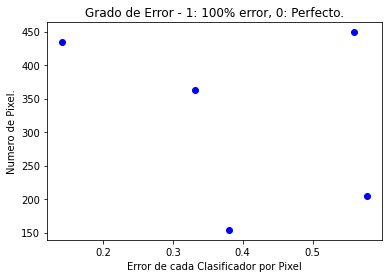

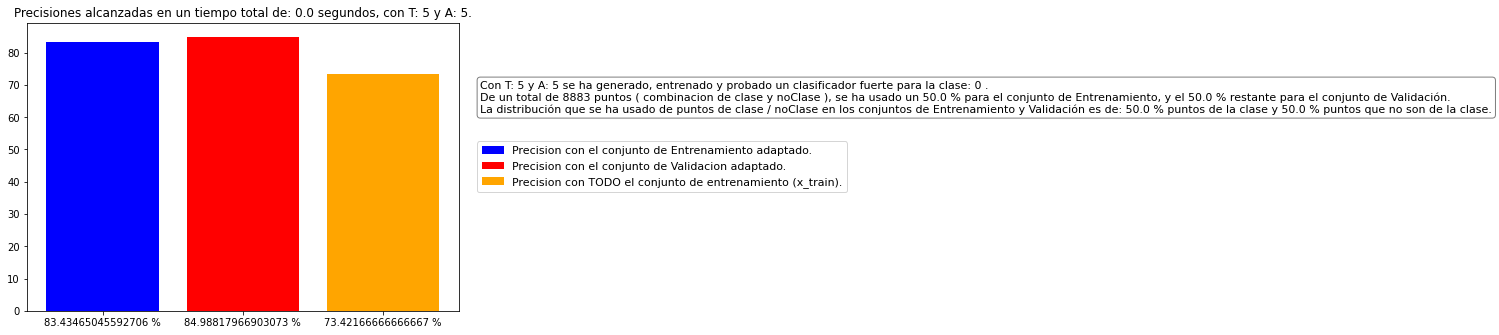

In [ ]:
# Lanza adaboost, entrena, y prueba el clasificador fuerte generado, devuelve el clasificador, y sus errores probados en los conjuntos de entrenamiento, validacion y todo train.
#   además, muestra la gráfica de cada prueba.

# analizar(T, A, clase, porcentaje_cojunto, porcentaje_clase, X, Y)
# analizar() devuelve [HT,  Error x_train, Error entrenamiento, Error validacion].

# En este caso, guardamos en la variable dump lo que devuelve la funcion, para que no se muestre por consola y se llene de basura.
#  de momento no nos interesa usar los datos que devuelve esta funcion.
dump = analizar(5, 5, 0, 0.5, 0.5, x_train, y_train)

Como podemos ver, comparando la precisión entre entrenamiento, validación y x_train entero, tener 5 clasificadores debiles nos proporciona una prediccion bastante aleatoria **( re-ejecuta el bloque anterior para ver que los valores de x_train varian drasticamente )** , teniendo en cuenta que hay como minimo 700 pixeles, 5 no parecen ser suficientes, pero por curiosidad vamos probar si con 5 T de alta calidad hay algún cambio.

Para ello probaremos con A: 100, 100 pruebas para obtener 5 ht de alta calidad.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 5/5 [00:00<00:00, 40.30it/s]


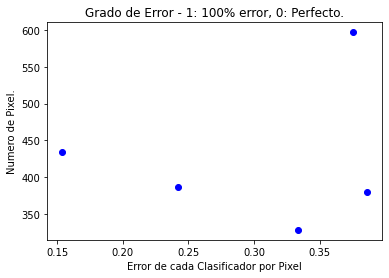

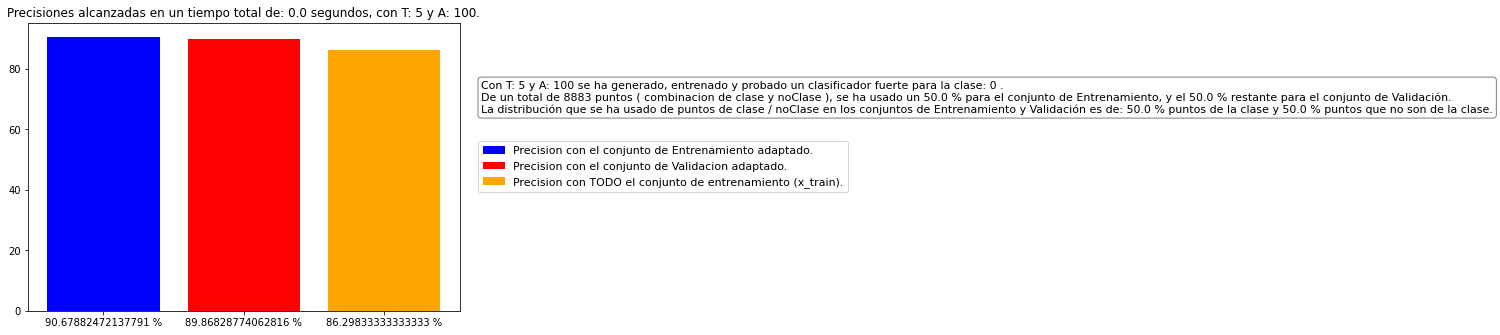

In [ ]:
dump = analizar(5, 100, 0, 0.5, 0.5, x_train, y_train)

Podemos ver que 100 intentos han sido suficientes como para hacer que el % de error de x_train no baje del 70%, mientras que los valores de validación se han estabilizado casi del todo.

Vamos a probar a aumentar T en este caso, teniendo en cuenta que hay mas de 700 pixeles, 5 clasificadores parece bastante pobre, vamos a intentar meter 50 en vez de 5, y a ver que pasa.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 50/50 [00:00<00:00, 79.52it/s]


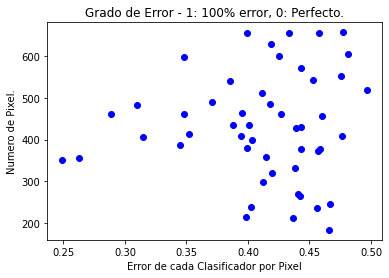

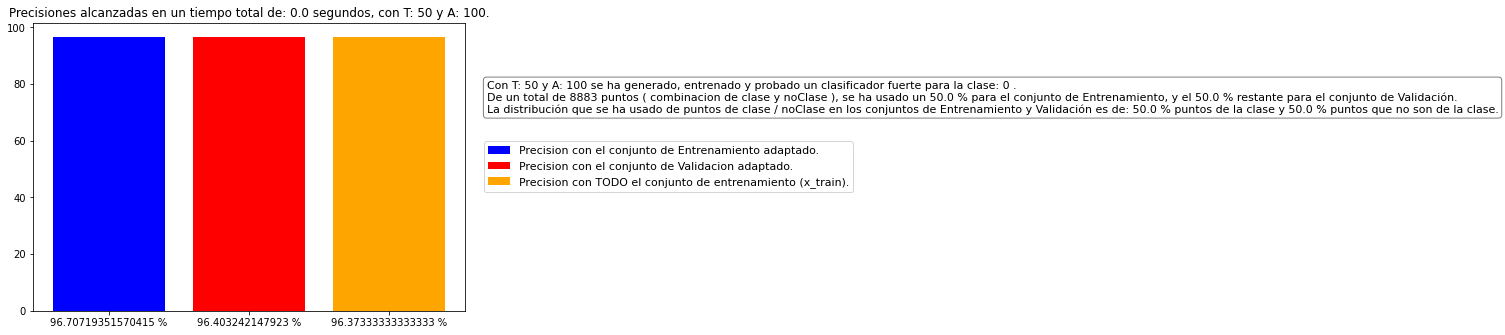

In [ ]:
dump = analizar(50, 100, 0, 0.5, 0.5, x_train, y_train)

Wow, ahora el % de precisión de x_train no baja del 95%, parece ser que 100 es nuestro numero mágico, de todas maneras, vamos a probar a aumentar T y A, 
vamos a primero intentar aumentar T y ver que pasa.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:03<00:00, 79.61it/s]


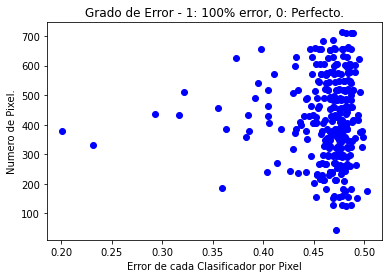

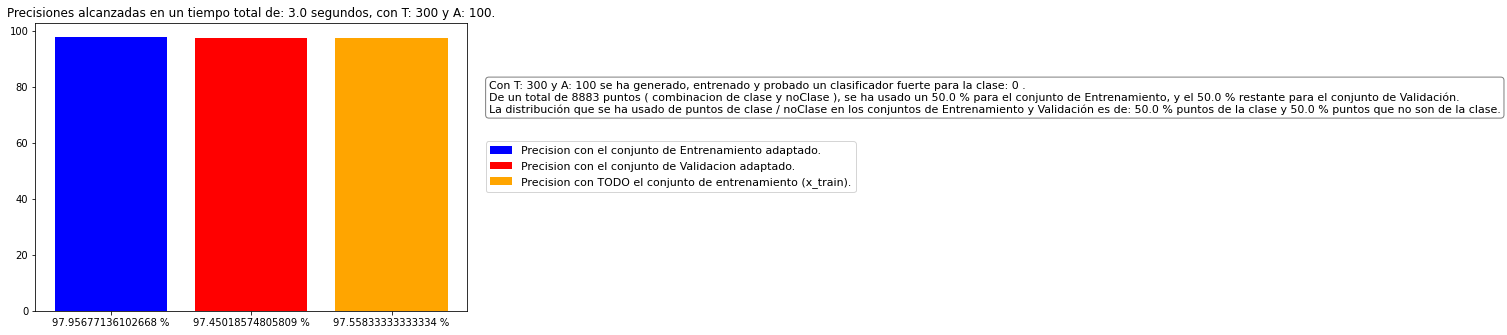

In [ ]:
dump = analizar(300, 100, 0, 0.5, 0.5, x_train, y_train)

Con T 300 y A 100 parece que hubo un poco de mejora, gastando un poco de tiempo extra.

No hay que olvidar que de momento, tanto la cantidad de imágenes de clase / noclase son el 50% para entrenamiento y validación, y que el % de imágenes de entrenameinto / validación tambien son 50%, vamos a cambiar dichos % y a ver que sucede.

<br>

Primero cambiaremos el % de conjuntos de entrenamiento / validación.

Probaremos con un 20% entrenamiento y 80% validación, y viceversa.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:02<00:00, 141.34it/s]


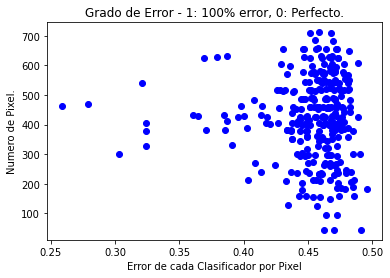

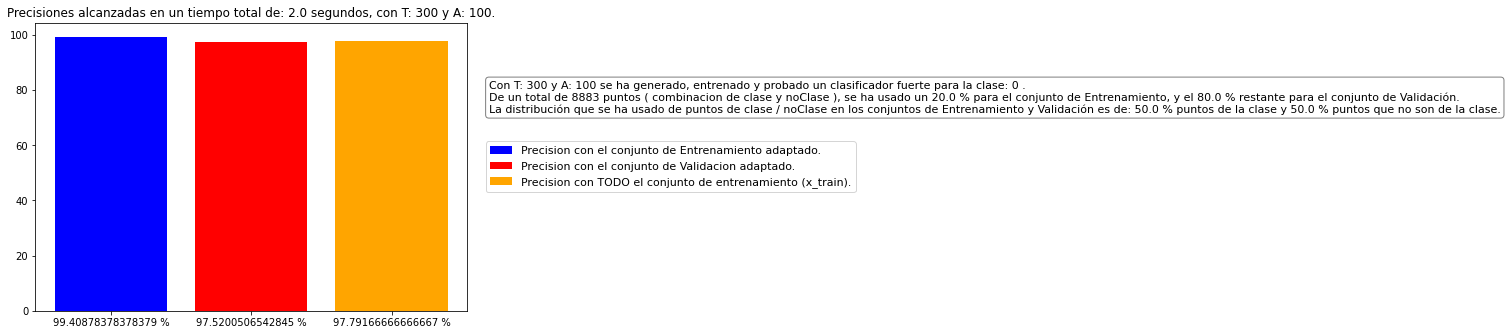

In [ ]:
# analizar(T, A, clase, porcentaje_cojunto, porcentaje_clase, X, Y)
dump = analizar(300, 100, 0, 0.2, 0.5, x_train, y_train)

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:05<00:00, 51.97it/s]


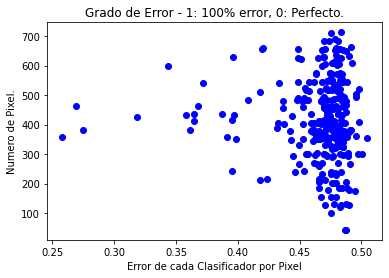

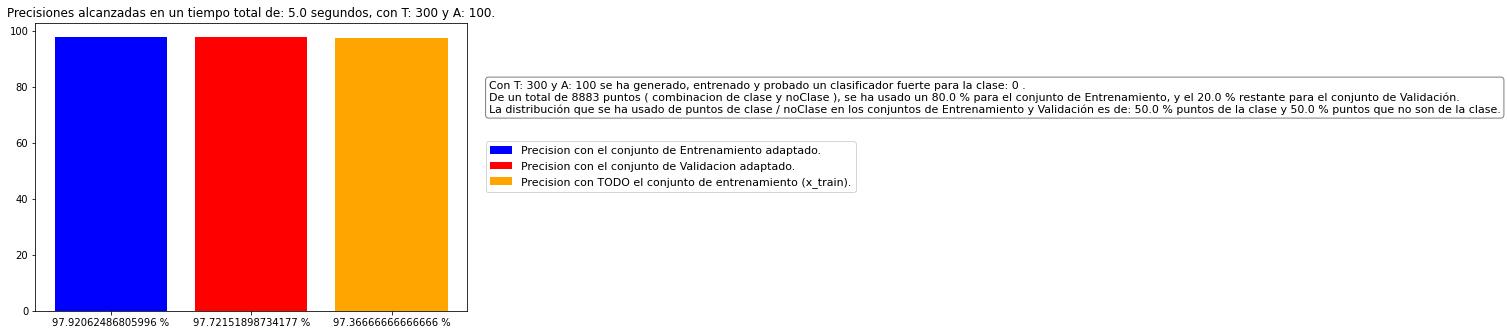

In [ ]:
dump = analizar(300, 100, 0, 0.8, 0.5, x_train, y_train)

En temas de precisión podemos observar que no hay una gran diferencia, 0.3% - 0.5% en x_train.

Pero lo interesante está en la gráfica de clasificadores y el tiempo, podemos observar que pasamos de 2s a 7s, y que además los clasificadores del 20% entrenamiento / 80% validación *( primera gráfica )* tiene clasificadores mucho más precisos *( los clasificadores están más dispersos hacia la izq, lo que significa que hay clasificadores con menor error )*, lo que explicaria ese 0.3% - 0.5% de mejora.

<br>

Hemos descubierto que con menos imágenes, obtenemos menores errores.

Y no solo para x_train, sino tambien si le pasamos el conjunto de entrenamiento y validación, y comparamos su precisión.

<br>

Vamos a probar la misma prueba pero con T 50, a ver si la variación del resultado se pronuncia.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 50/50 [00:00<00:00, 148.29it/s]


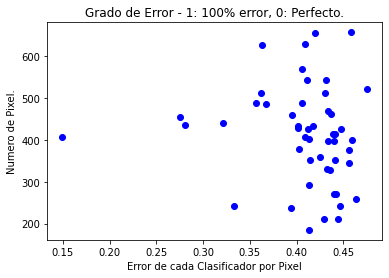

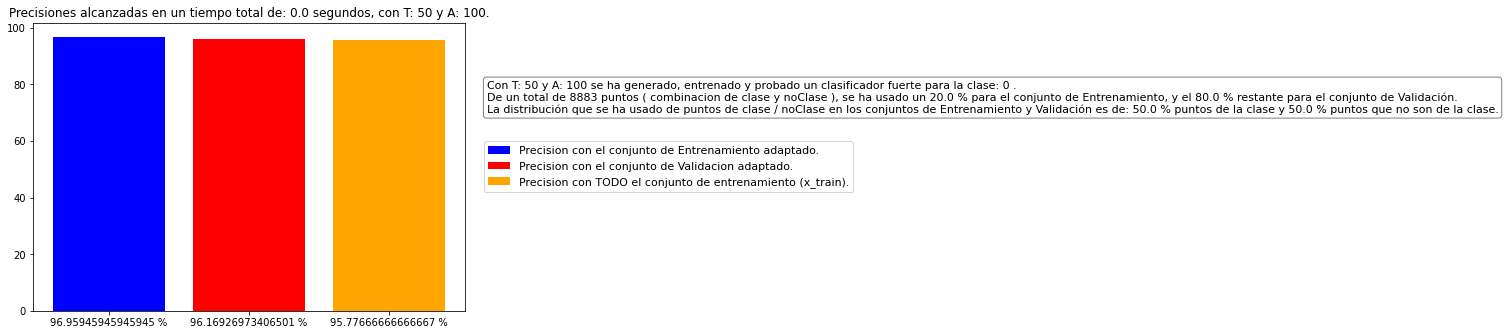

In [ ]:
# analizar(T, A, clase, porcentaje_cojunto, porcentaje_clase, X, Y)
dump = analizar(50, 100, 0, 0.2, 0.5, x_train, y_train)

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 50/50 [00:01<00:00, 50.00it/s]


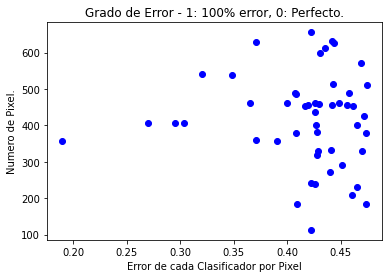

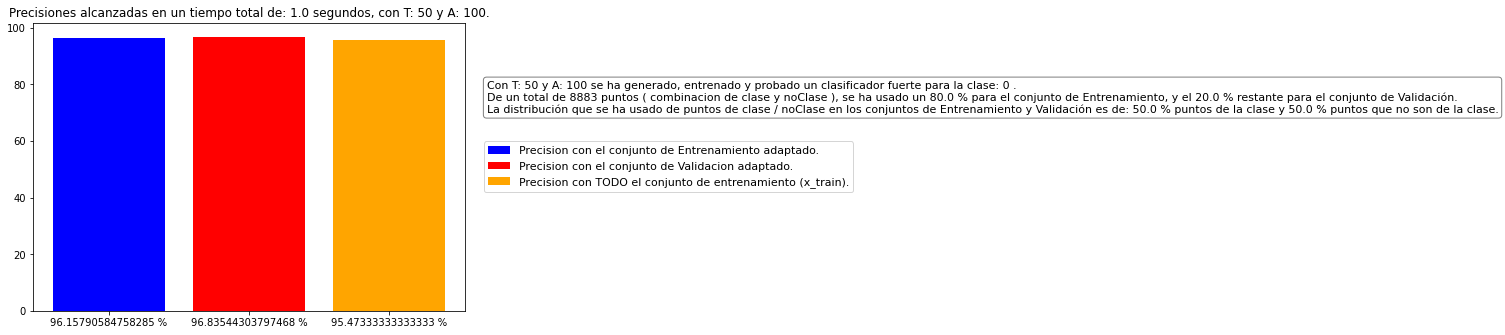

In [ ]:
dump = analizar(50, 100, 0, 0.8, 0.5, x_train, y_train)

Al parecer en el caso en el que hay menos Ts, el resultado es el contrario, es probable que el % de error ahora se vea afectado por la aleatoriedad nuevamente.

<br>

De todas maneras, vamos a probar con 20% / 80%, un punto intermedio balanceado hacia el resultado del analisis anterior, ya que parece ser el mejor valor hasta el momento.

<br> 

Vamos a intentar ahora alterar la cantidad de imágenes que tendrán el conjunto de entrenamiento y de validación de la clase a entrenar.

Para este caso, vamos a probar 20% / 80%, para 20%, 50% y 80% de distribición entre conjunto de entrenamiento y validación, con T 300.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:09<00:00, 30.38it/s]


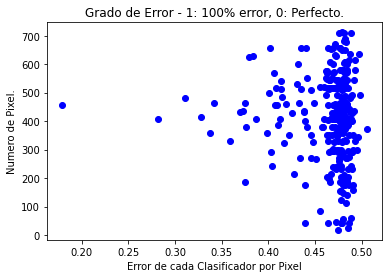




-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:02<00:00, 116.34it/s]


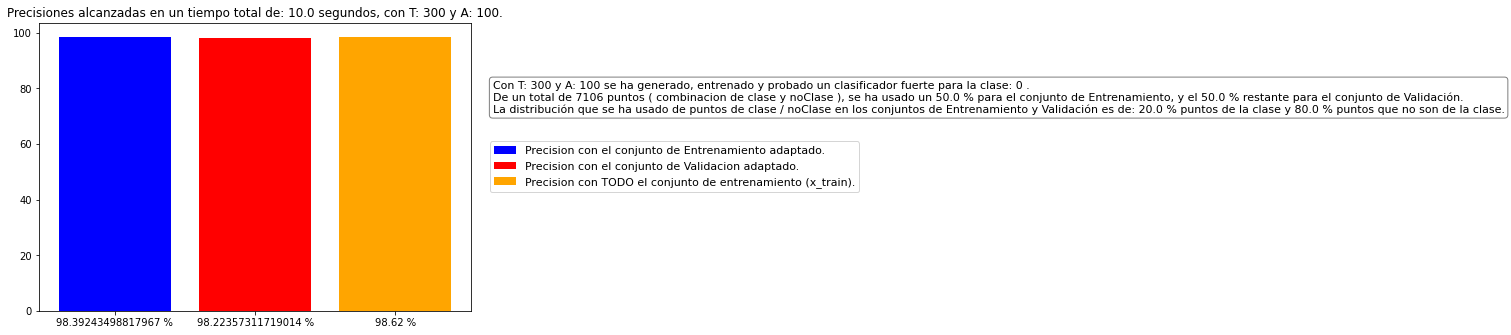

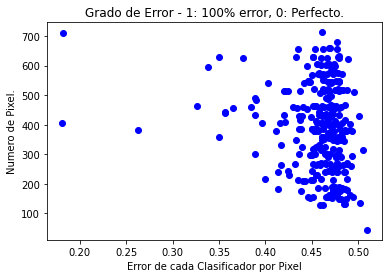




-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:03<00:00, 76.62it/s]


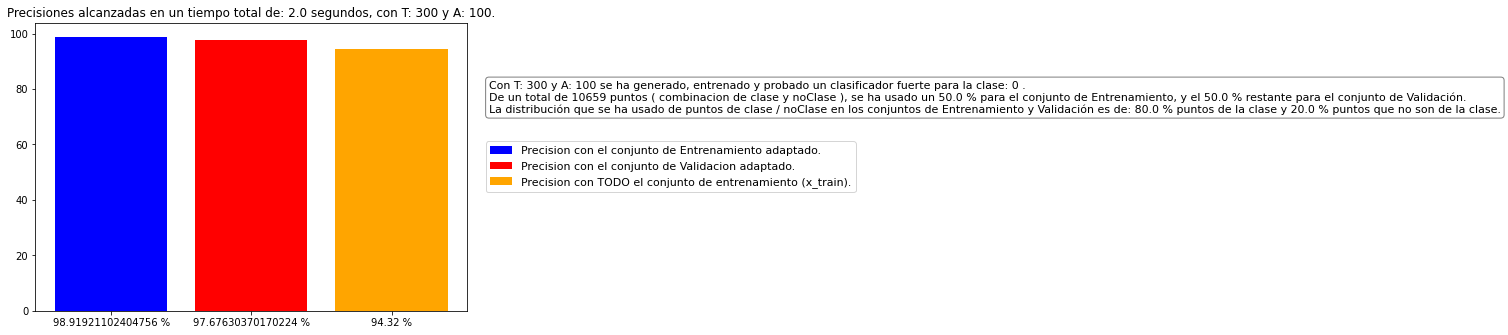

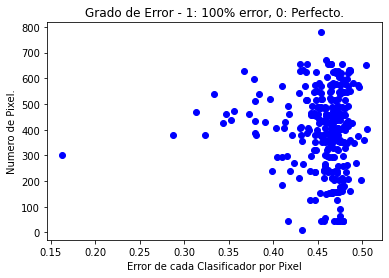




-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:01<00:00, 166.86it/s]


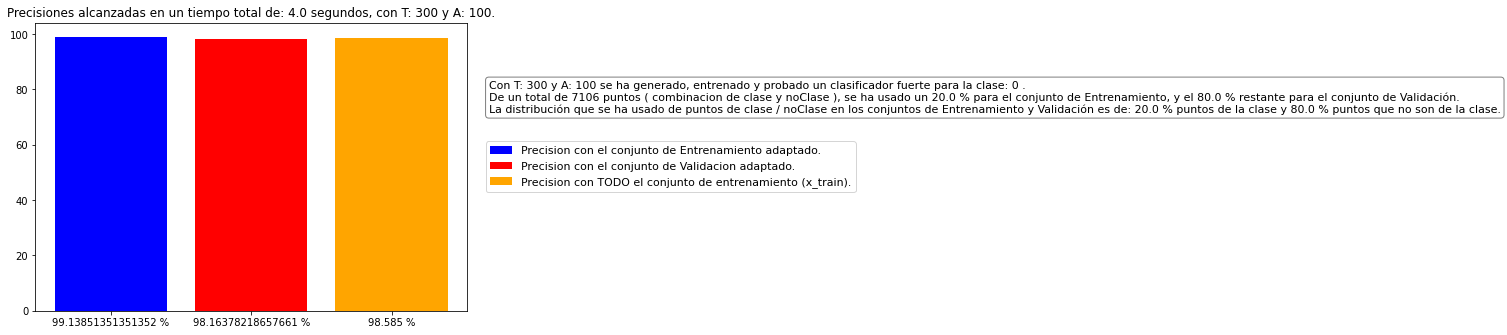

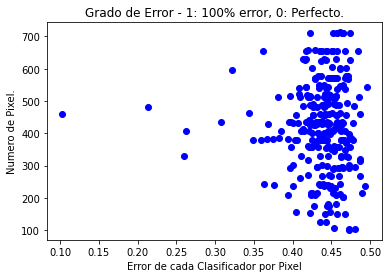




-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:16<00:00, 17.87it/s]


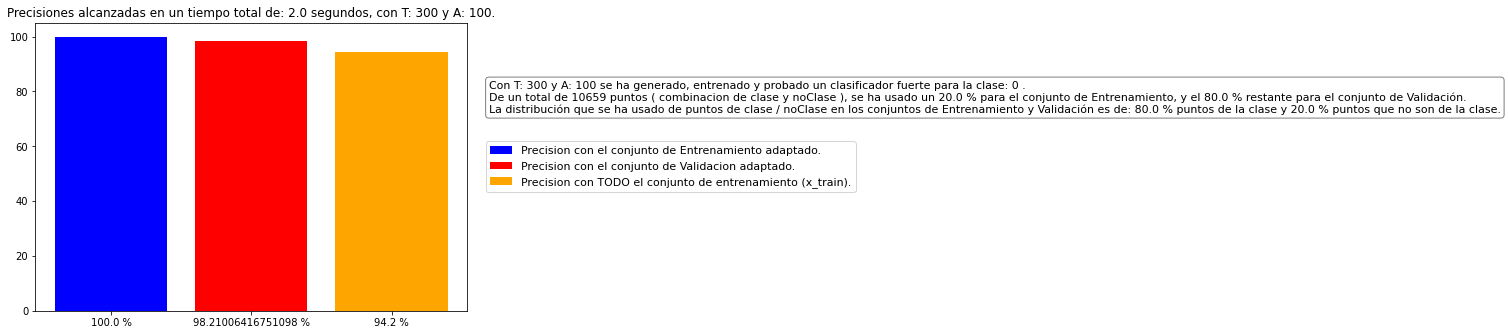

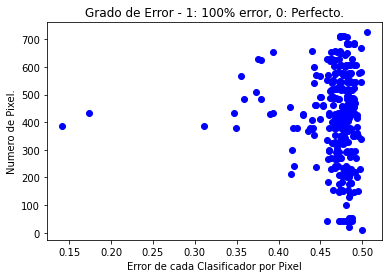




-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:03<00:00, 81.41it/s]


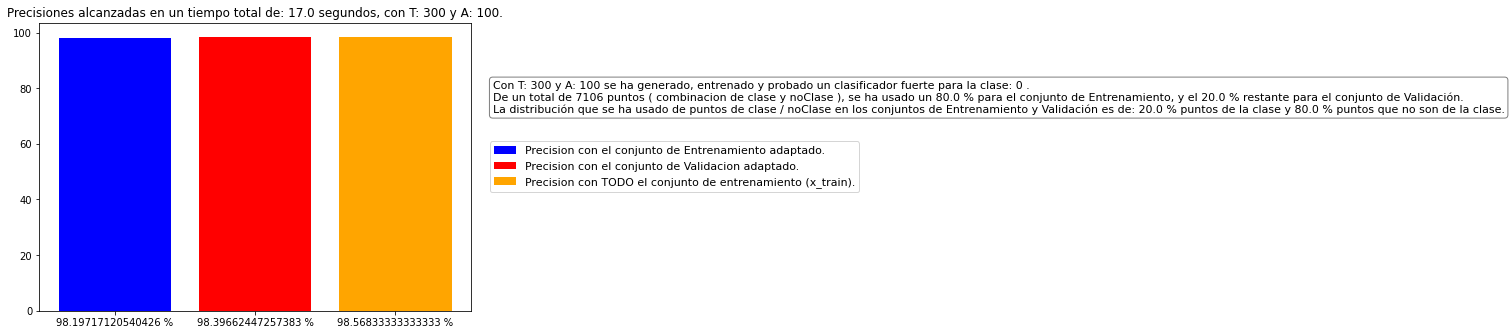

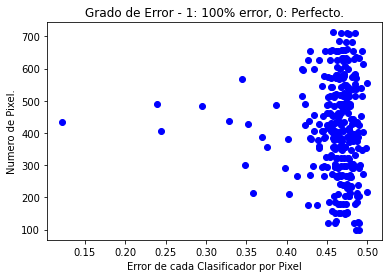

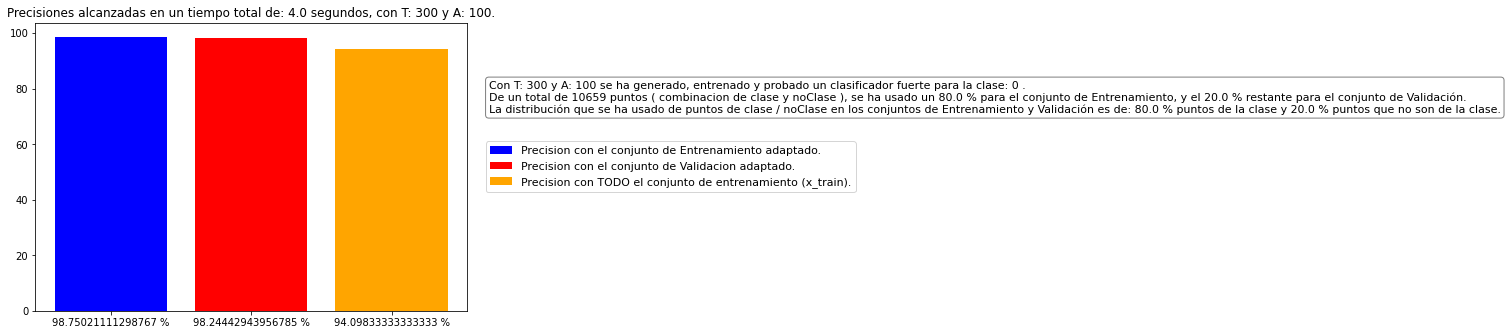

In [ ]:
# analizar(T, A, clase, porcentaje_cojunto, porcentaje_clase, X, Y)
dump = analizar(300, 100, 0, 0.5, 0.2, x_train, y_train)
dump = analizar(300, 100, 0, 0.5, 0.8, x_train, y_train)

dump = analizar(300, 100, 0, 0.2, 0.2, x_train, y_train)
dump = analizar(300, 100, 0, 0.2, 0.8, x_train, y_train)

dump = analizar(300, 100, 0, 0.8, 0.2, x_train, y_train)
dump = analizar(300, 100, 0, 0.8, 0.8, x_train, y_train)

De esta prueba y en combinación con las pruebas anteriores podemos sacar varias conclusiones:

- Mientras menos imágenes de la clase tegamos, más puristas serán nuestros clasificadores, dandonos una mayor precisión, pero a su vez, el tiempo que tarda en entrenar aumenta drasticamente dependiendo de la cantidad de Ts y As.

- La cantidad de imágenes para el conjunto de entrenamiento / validación depende de la cantidad total que tengamos de imágenes de la clase, no podemos asumir que siempre un conjunto de entrenamiento grande nos va ayudar siempre.

- Si nuestro conjunto de entrenamiento es pequeño, el % de precisión puede llegar a ser del 100%, resultado que ya no nos serviria de mucho para compara con el resto, ya que adaboost podria haber sobreentrenado sobre dicho conjunto.

<br>

En nuestro caso, el caso que mejor resultado nos ha dado ha sido tener un 80% entrenamiento / 20% validación, y en esos conjuntos tener un 20% imágenes de la clase, y otro 80% que no sean de la clase. Esto se debe a que al haber un conjunto de entrenamiento grande, con pocas imágenes de la clase hace que el entrenamiento sea más exaustivo.

El sobreentrenamiento, aunque dificil de experimentar en adaboost debido a su constante equilibramiento usando D, sigue siendo posible en casos especificos, esto se puede detectar cuando el error en el conjunto de validación es extremadamente mayor en comparación con el error en el conjunto de entrenamiento, esto se debe a que el clasificador ha entrenado enfocandose concretamente en el conjunto de entrenamiento en vez de generalizar.

<br>

Tambien se puede dar el caso en el cual el clasificador obtenga un alto % de precisión en x_train debido a que se adecua a que, al haber menor imágenes de la clase en el conjunto de entrenamientp, si clasifica como noclase la mayoria de imágenes, este obtiene una mayor precisión, esto se puede comprobar pasandole un conjunto con un % inverso ( 80% imágenes de la clase, y 20% imágenes de no clase, y ver que sucede ), y es justo lo que vamos a hacer para confirmar de que el mejor caso que hemos seleccionado: 20% imagenes de clase / 80% imagenes de no clase, 80% entrenameinto / 20% validación, 300T, 100A.

<br>
Si el resultado es un alto % de precision, entonces es que ha entrenado bien.

Si tiene un menor % de precisión, entonces es que está sucediendo lo que hemos explicado anteriormente.

<br>

**Hay que tener en cuenta que adaboost se equilibra durante el entrenamiento, asi que tanto esta situación como el sobreentrenamiento, si suceden, habrá que fijarse en que % de error oscilará de manera minima pero considerable, como por ejemplo entre 5% - 10% de error.**

---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 5923
| Num. total de numeros de la !clase: 54077
| Pos. inicio introducido: 0
| Pos. final introducido: 5923
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 20.0% (5923).
| Porcentaje complementario de noClase: 80.0% (23692).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 29615
| Len de X e Y: 29615, 29615
--------------------------------------------------------------------
-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 300/300 [00:17<00:00, 16.97it/s]


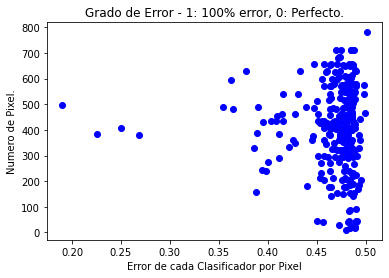

---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 515, Numeros total de imágenes: 29615
| Precision: 98.26101637683607 %
| Error: 1.7389836231639373 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 5923
| Num. total de numeros de la !clase: 54077
| Pos. inicio introducido: 0
| Pos. final introducido: 5923
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 80.0% (5923).
| Porcentaje complementario de noClase: 20.0% (1480).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 7403
| Len de X e Y: 7403, 7403
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 275, Numeros total de imágenes: 7403
| Precision

In [ ]:
# Cantidad total de 0s en x_train: 5923
# S = 0
# E = 5923
# Siendo ese 5923 el 20% de imágnes del total de X para entrenar el clasificador fuerte.

globalprint = True

(X, Y) = adaptar_conjunto_entrenamiento(0, 5923, 0.2, clase, x_train, y_train)
X = X.reshape(len(X), 28 * 28)

H0 = adaboost(X, Y, 300, 100)


# Ya que estamos, vamos a ver su resultado tambien.
probar_clasificador_fuerte(X, Y, H0)


# Ahora el 5923 de imágenes de la clase sera el 80% de imágnes del total de X para comprobar si está sucediendo lo mencionado anteriormente.
(X, Y) = adaptar_conjunto_entrenamiento(0, 5923, 0.8, clase, x_train, y_train)
X = X.reshape(len(X), 28 * 28)

# Vamos a ver su resultado.
probar_clasificador_fuerte(X, Y, H0)

globalprint = False

Parece que es justo lo que temiamos, pasamos de tener un 98.3% a un 96.2%, pero no parece que hayan tanto clasificadores como para que este patron de entrenamiento erroneo haga que el % de precisión disminuya mucho.

<br>

De todas maneras, 20s de entrenamiento para que adaboost adapte un patron de entrenamiento especifico es una basura.




## Escogiendo T y A adecuados.

Teniendo en cuenta todos los resultados anteriores, vamos a probar aumentando el numero de imágenes de la clase ( de 20% a 30% ), disminuyendo T a 150, y aumentando A a 300, por ejemplo.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:14<00:00, 10.70it/s]


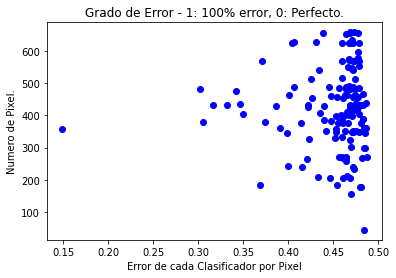

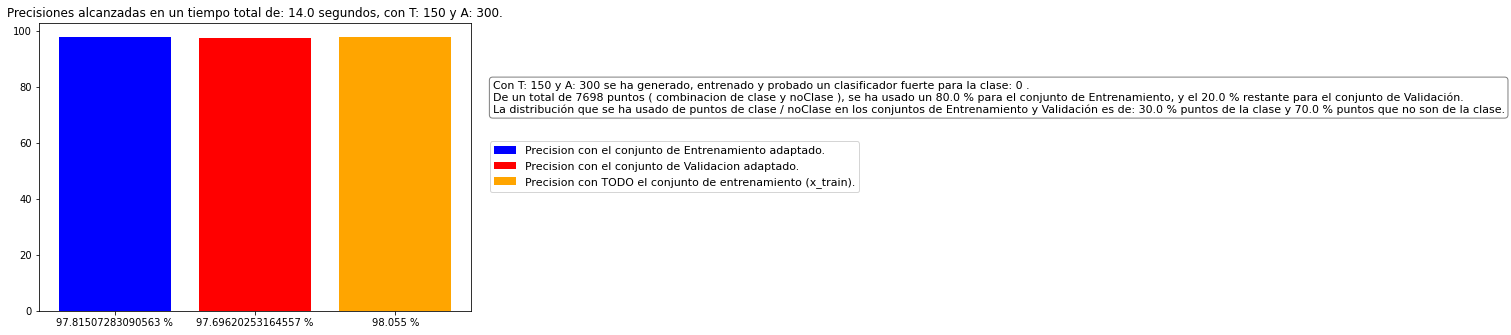

In [ ]:
# analizar() devuelve [HT, Error entrenamiento, Error validacion, Error x_train].
HT0 = analizar(150, 300, 0, 0.8, 0.3, x_train, y_train)

In [ ]:
globalprint = True

(X, Y) = adaptar_conjunto_entrenamiento(0, 5923, 0.2, clase, x_train, y_train)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT0[0])

(X, Y) = adaptar_conjunto_entrenamiento(0, 5923, 0.9, clase, x_train, y_train)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT0[0])

globalprint = False

---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 5923
| Num. total de numeros de la !clase: 54077
| Pos. inicio introducido: 0
| Pos. final introducido: 5923
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 20.0% (5923).
| Porcentaje complementario de noClase: 80.0% (23692).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 29615
| Len de X e Y: 29615, 29615
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 631, Numeros total de imágenes: 29615
| Precision: 97.8693229782205 %
| Error: 2.1306770217795035 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 5923
| Num. total de numeros de la 

Vale, tras la prueba anterior, podemos ver que no hay patrones de sobreentrenamiento, y el error es aceptable ( ~3% mas o menos).

Por el momento estos serán los valores que usaremos para entrenar el clasificador de 0s:

- T: 150
- A: 300
- Entrenamiento / Validacion: 80% / 20%
- Clase / noClase: 30% / 70%

<br>

Hemos visto que desde T: 50 y A: 100 ya empieza a dar resultados buenos, vamos a intentar aumentar bastante ambos valores, para ver si el aumento en % de preicisón renta el tiempo invertido.

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 500/500 [01:45<00:00,  4.73it/s]


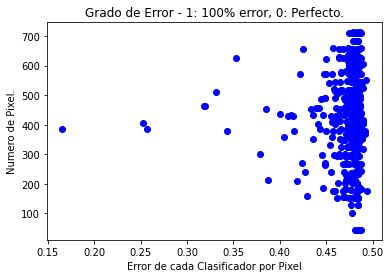

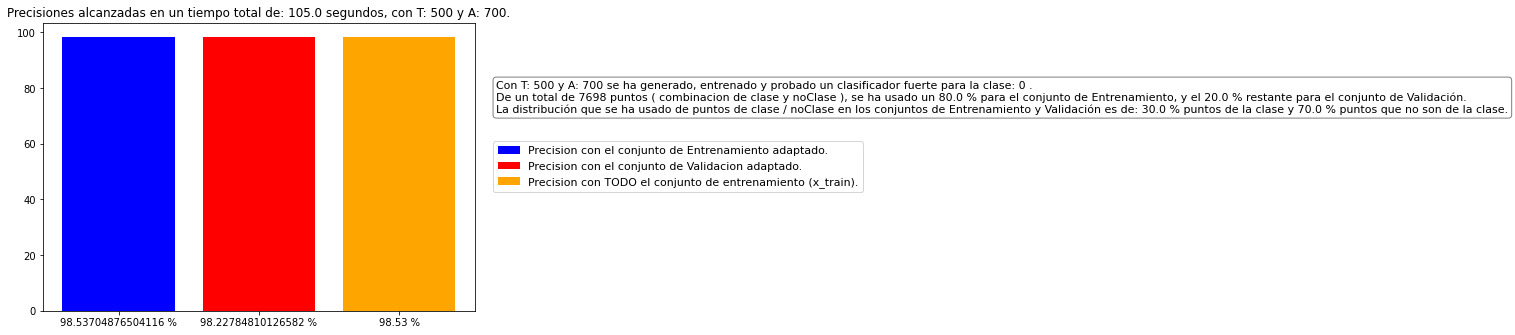

In [ ]:
dump = analizar(500, 700, 0, 0.8, 0.3, x_train, y_train)

Como podemos ver, el tiempo invertido es demasiado, no nos renta tener tantos clasifiacores.

<br>

El rango de T y A que recomiendo usar es de T: 100 - 300, y A: 300 - 500.


La distribución de imágenes de clase y noClase es la de 30% / 70%, o mejor dicho, tener un poco más imágenes de otras clases que de la clase a entrenar, usado en conjunto con la distribución de conjuntos de entrenamiento / validación.

La distribución de imágenes entre entrenameinto y validación es la de 80% entrenamiento 20% validación, usado en conjunto con la distribución de imágenes de clase.

<br>


*Como he explicado en el apartado anterior, tener pocas imágenes de la clase renta solo cuando tu conjunto de entrenameinto es grande.*

## Prueba

Ya que estamos, vamos a probar con x_test el clasificador `HT0` que hemos entrenado con los parametros anteriormente mencionados.

In [ ]:
globalprint = True

clase = 0

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT0[0])


# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT0[0])


# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT0[0])

globalprint = False

---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 980
| Num. total de numeros de la !clase: 9020
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 22, Numeros total de imágenes: 666
| Precision: 96.69669669669669 %
| Error: 3.303303303303303 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 980
| Num. total de numeros de la !clase: 9020
| Po

## Conclusión


`HT0` presenta una Precision de ~98% con el conjunto de test entero, una Precision de ~98 % con el conjunto de test adaptado de tal manera que X tiene un 90% de imágenes de 0s, y una Precision de ~98 % con el conjunto de test adaptado de tal manera que X tiene un 10% de imágenes de 0s.

**LOS RESULTADOS PUEDEN VARIAR DEPENDIENDO DE LA RE-EJECUCIÓN DEL ENTRENAMIENTO, PERO SOLO OSCILAN UN MÁXIMO DE 1%+-**

En resumen, nuestro `HT0` está entrenado como es debido.

<br>

Para el entrenamiento del resto de clases, usare los valores anteriores como valores iniciales, y en caso de que no me sirvan, haré un analisis de los T y A para encontrar unos valores adecuados para entrenar dichas clases.

# Adaboost para N clases - Numeros 1 - 9.

Vamos a entrenar un adaboost para el resto de clases, usando los valores que hemos analizado y escogido al entrenar la clase 0, ver sus resultados y probarlo.

<br>

Valores:
- T: 150
- A: 300
- Entrenamiento / Validacion: 80% / 20%
- Clase / noClase: 30% / 70%

Consideraré un clasificador fuerte como aceptable un % de precisión en el conjunto validación superior al 90%.

Si alguno no llega al 90%, realizaré un analisis de T y A para dicha clase.

Estos valores parecen buenos, vamos a probarlos con el conjunto de test.

## Análisis y Prueba - Clase 1

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:16<00:00,  8.99it/s]


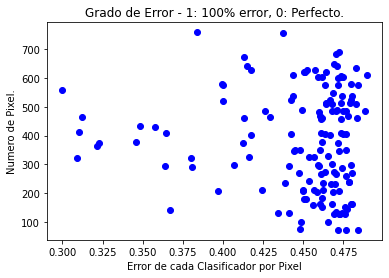




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1135
| Num. total de numeros de la !clase: 8865
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 13, Numeros total de imágenes: 666
| Precision: 98.04804804804805 %
| Error: 1.951951951951952 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1135
| Num. total de numeros de la !clase: 8865

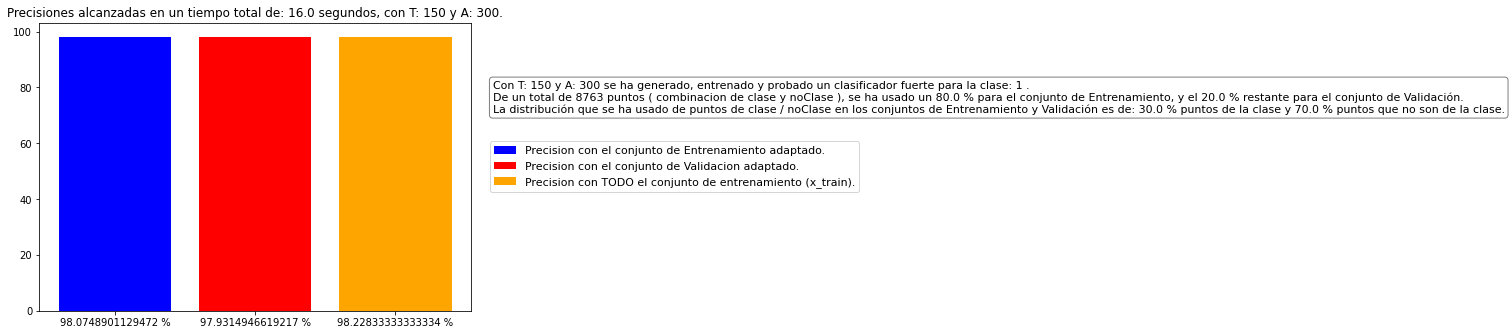

In [ ]:
clase = 1

# Análisis
HT1 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT1[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT1[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT1[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

## Análisis y Prueba - Clase 2

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:15<00:00,  9.42it/s]


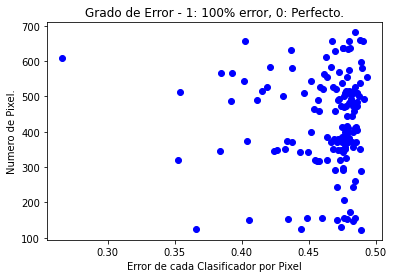




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1032
| Num. total de numeros de la !clase: 8968
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 78, Numeros total de imágenes: 666
| Precision: 88.28828828828829 %
| Error: 11.711711711711711 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1032
| Num. total de numeros de la !clase: 896

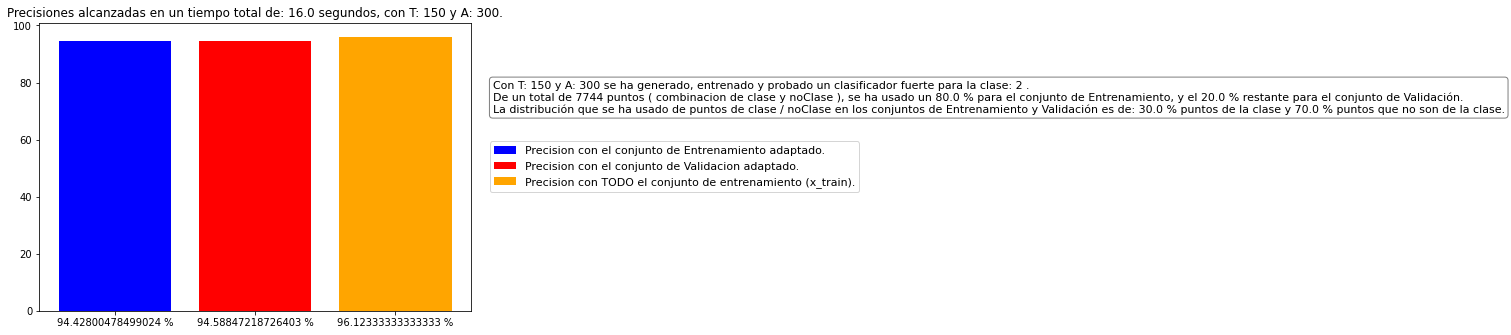

In [ ]:
clase = 2

# Análisis
HT2 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT2[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT2[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT2[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

## Análisis y Prueba - Clase 3

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:14<00:00, 10.19it/s]


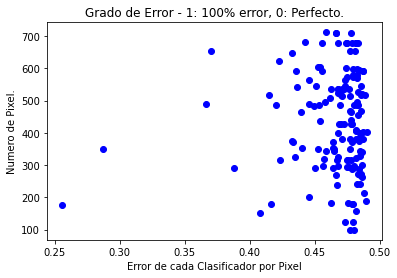




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1010
| Num. total de numeros de la !clase: 8990
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 94, Numeros total de imágenes: 666
| Precision: 85.88588588588588 %
| Error: 14.114114114114114 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1010
| Num. total de numeros de la !clase: 899

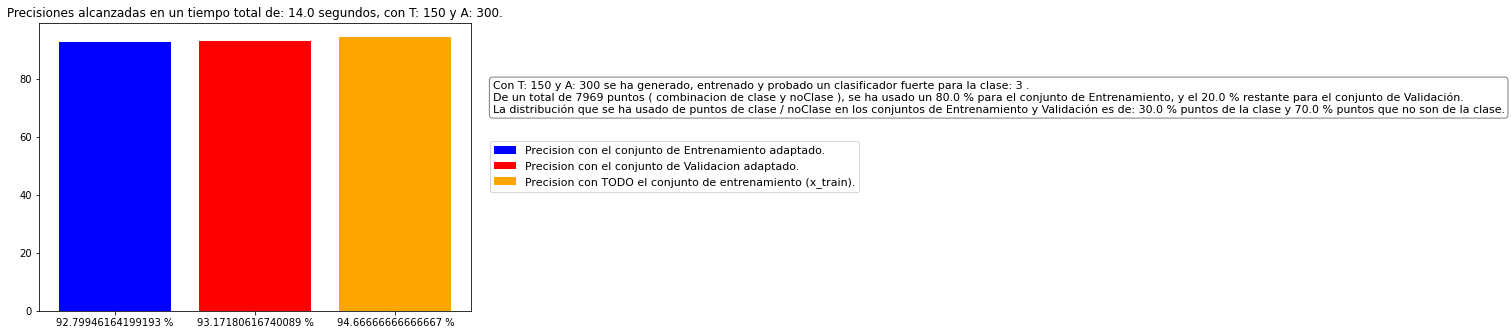

In [ ]:
clase = 3

# Análisis
HT3 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT3[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT3[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT3[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

## Análisis y Prueba - Clase 4

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:14<00:00, 10.60it/s]


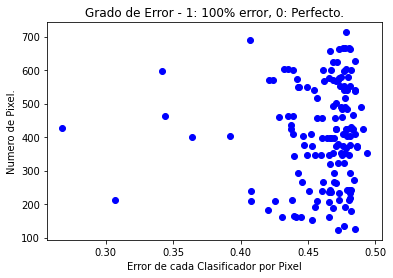




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 982
| Num. total de numeros de la !clase: 9018
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 72, Numeros total de imágenes: 666
| Precision: 89.1891891891892 %
| Error: 10.81081081081081 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 982
| Num. total de numeros de la !clase: 9018
| 

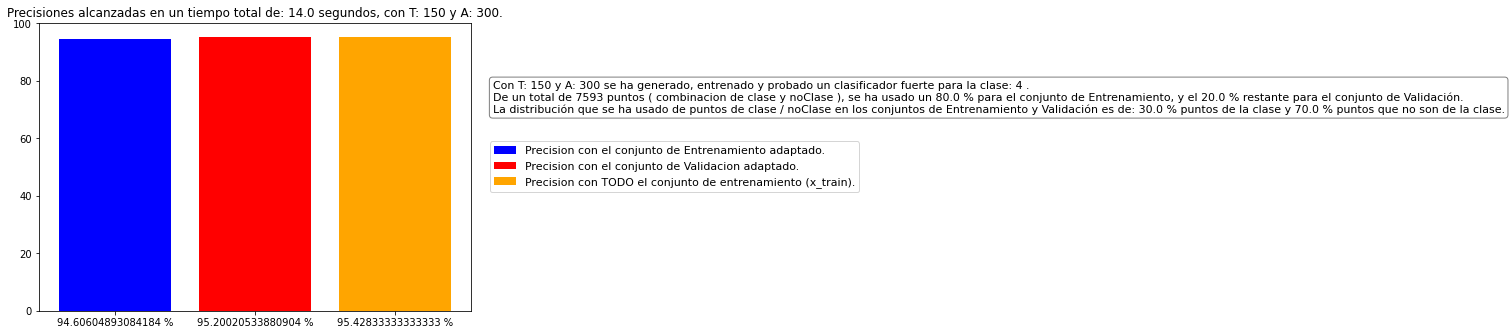

In [ ]:
clase = 4

# Análisis
HT4 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT4[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT4[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT4[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

## Análisis y Prueba - Clase 5

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:14<00:00, 10.68it/s]


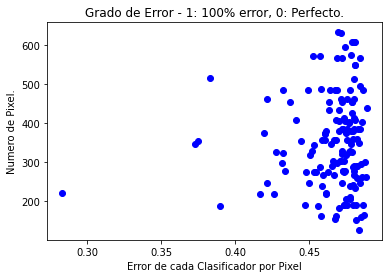




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 892
| Num. total de numeros de la !clase: 9108
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 106, Numeros total de imágenes: 666
| Precision: 84.08408408408408 %
| Error: 15.915915915915916 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 892
| Num. total de numeros de la !clase: 9108

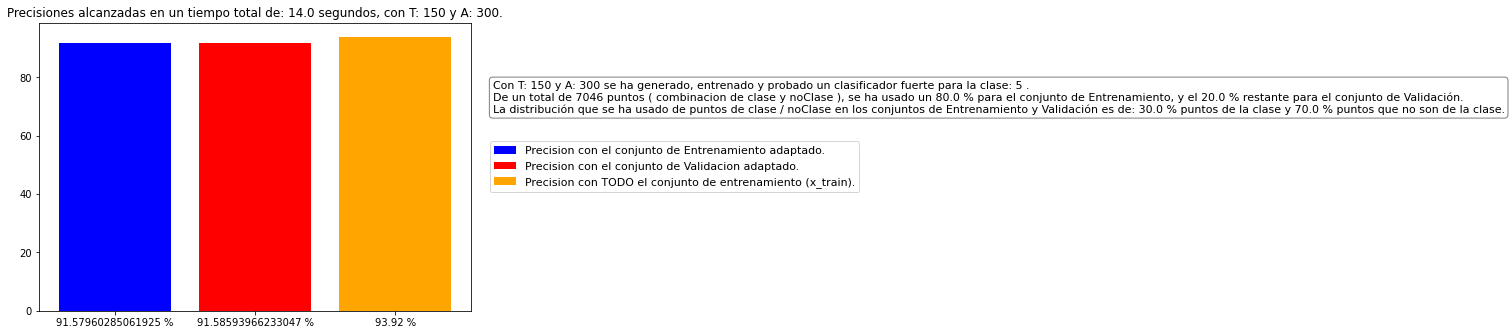

In [ ]:
clase = 5

# Análisis
HT5 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT5[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT5[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT5[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

## Análisis y Prueba - Clase 6

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:17<00:00,  8.82it/s]


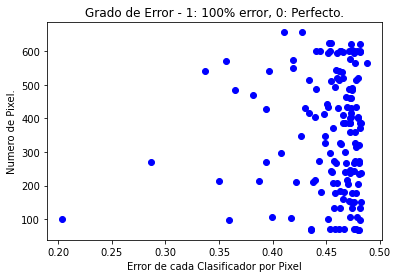




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 958
| Num. total de numeros de la !clase: 9042
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 62, Numeros total de imágenes: 666
| Precision: 90.69069069069069 %
| Error: 9.30930930930931 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 958
| Num. total de numeros de la !clase: 9042
| 

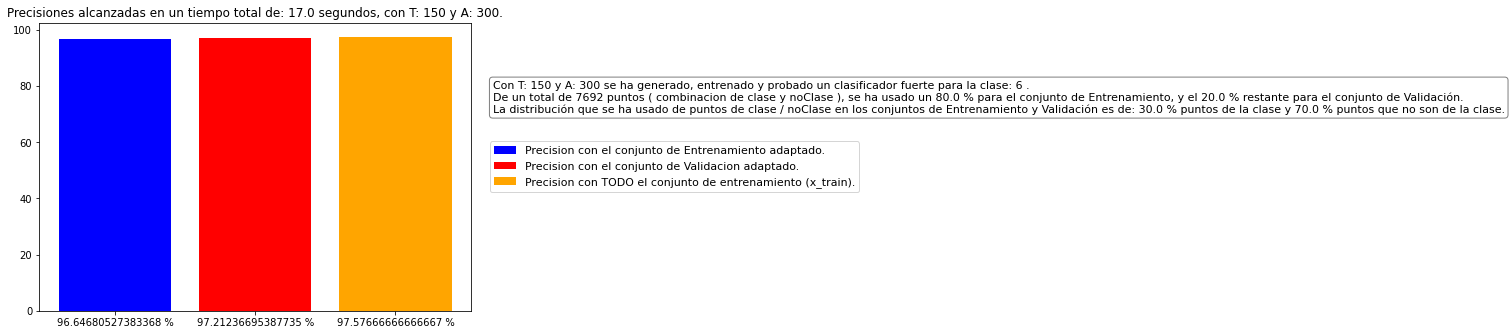

In [ ]:
clase = 6

# Análisis
HT6 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT6[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT6[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT6[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

## Análisis y Prueba - Clase 7

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:17<00:00,  8.46it/s]


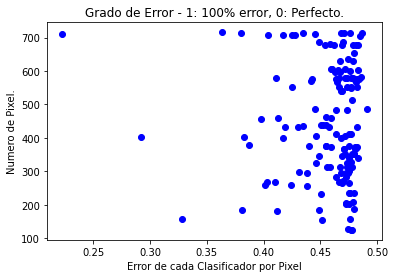




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1028
| Num. total de numeros de la !clase: 8972
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 67, Numeros total de imágenes: 666
| Precision: 89.93993993993993 %
| Error: 10.06006006006006 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1028
| Num. total de numeros de la !clase: 8972

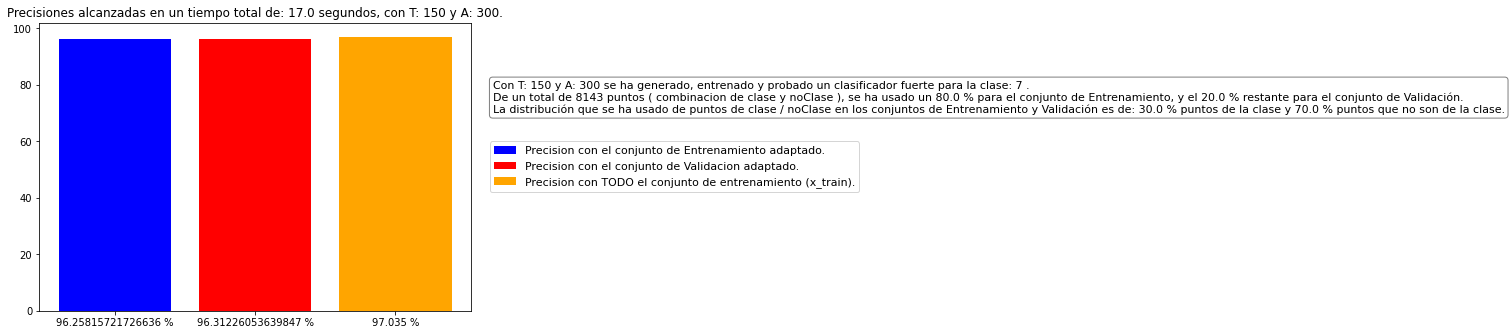

In [ ]:
clase = 7

# Análisis
HT7 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT7[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT7[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT7[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

## Análisis y Prueba - Clase 8

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:16<00:00,  8.88it/s]


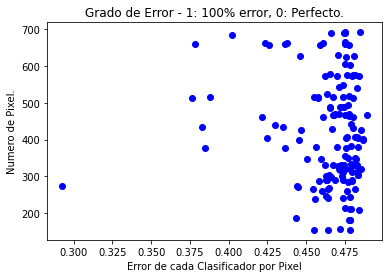




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 974
| Num. total de numeros de la !clase: 9026
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 117, Numeros total de imágenes: 666
| Precision: 82.43243243243244 %
| Error: 17.56756756756757 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 974
| Num. total de numeros de la !clase: 9026


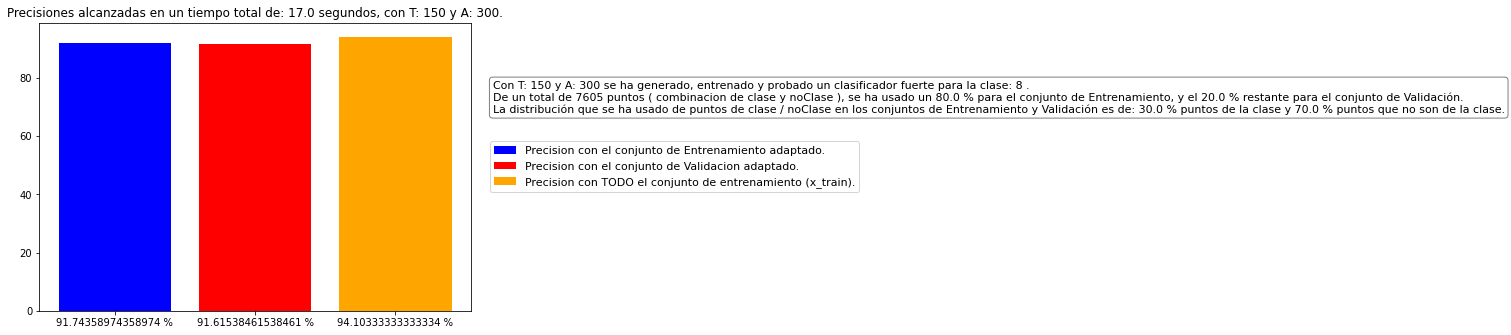

In [ ]:
clase = 8

# Análisis
HT8 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT8[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT8[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT8[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

## Análisis y Prueba - Clase 9

-------------------------- ⭐ ADA BOOST ⭐ ------------------------
| Entrenando...


100%|██████████| 150/150 [00:14<00:00, 10.40it/s]


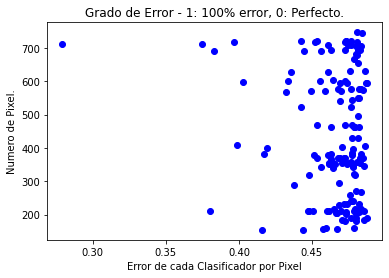




---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1009
| Num. total de numeros de la !clase: 8991
| Pos. inicio introducido: 0
| Pos. final introducido: 600
|-------------------------------------------------------------------
| Porcentaje de puntos de la Clase: 90.0% (600).
| Porcentaje complementario de noClase: 10.0% (66).
--------------------------------------------------------------------
| El tamaño del conjunto es de: 666
| Len de X e Y: 666, 666
--------------------------------------------------------------------
---------------- APLICAR Y CALCULAR ERROR H ------------------------

| Numero total de fallos: 85, Numeros total de imágenes: 666
| Precision: 87.23723723723724 %
| Error: 12.762762762762764 %
--------------------------------------------------------------------
---------------------- ADAPTADOR DE CONJUNTOS ----------------------
| Num. total de numeros de la clase: 1009
| Num. total de numeros de la !clase: 899

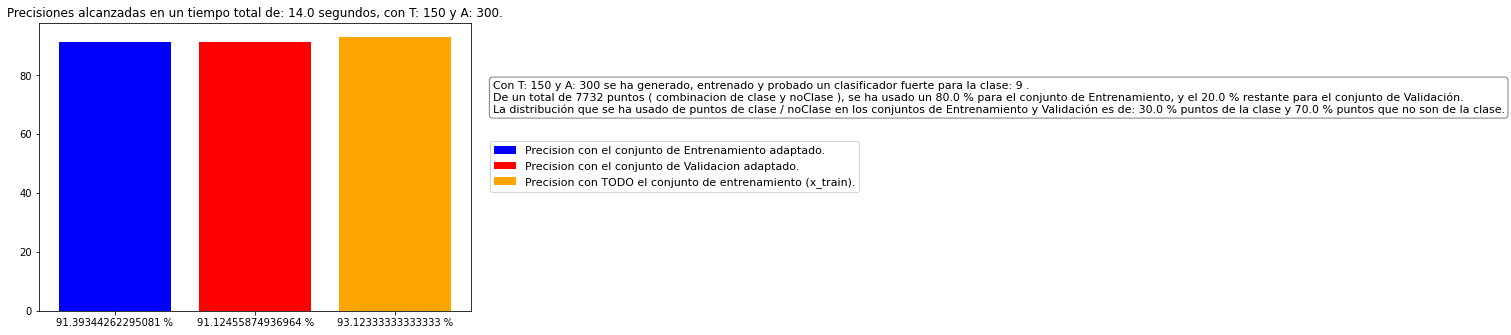

In [ ]:
clase = 9

# Análisis
HT9 = analizar(150, 300, clase, 0.8, 0.3, x_train, y_train)

# Y prueba con test
globalprint = True

# Vamos a probar adaptando el conjunto de tests, de tal manera que X contiene 90% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.9, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT9[0])

# Vamos a tambien probar adaptando el conjunto de tests, de tal manera que X contiene 10% imágenes de 0s.
(X, Y) = adaptar_conjunto_entrenamiento(0, 600, 0.1, clase, x_test, y_test)
X = X.reshape(len(X), 28 * 28)
probar_clasificador_fuerte(X, Y, HT9[0])

# Y ya que estamos, vamos a mandarle todo test a ver que % de error da.
X = x_test.reshape(len(x_test), 28 * 28)
Y = y_test

Y = np.int64(Y == clase)
Y[np.where(Y == 0)] = -1

# Aplicamos el clasificador al TODO el conjunto de tests, y vemos su error.
probar_clasificador_fuerte(X, Y, HT9[0])

globalprint = False

### Conclusión

Los resultados son aceptables, no hará falta cambiar los valores.

# Solución Adaboost.

A continuación vamos a usar el conjunto de test para clasificar todas las imágenes de este, usando todos los clasificadores combinados.

<br>

Anteriormente en el apartado de *Funciones de clasificación final* hemos hecho 2 métodos, `clasificar_individual` y `clasificar_conjunto`.

Vamos a usar `clasificar_individual` para ver **POR FIN** el resultado de nuestro trabajo, le pasaremos unas imágenes random de x_test a ver que nos devuelve.

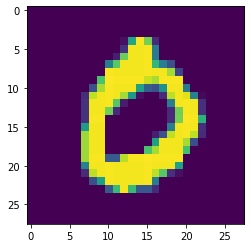


La imágen es un 0


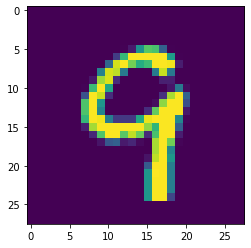


La imágen es un 9


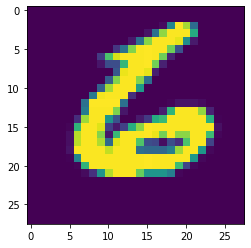


La imágen es un 6


In [ ]:
# Combinamos todos los clasificadores EN ORDEN
clasificadores = [HT0, HT1, HT2, HT3, HT4, HT5, HT6, HT7, HT8, HT9]

# Muestran el numero a clasificar, y de que numero son.
HTy = clasificar_individual(clasificadores, x_test[3], True, True)
HTy = clasificar_individual(clasificadores, x_test[150], True, True)
HTy = clasificar_individual(clasificadores, x_test[9999], True, True)

Maravilloso...

Ahora vamos a usar `clasificar_conjunto` para calcular la precisión de todos nuestros clasificadores en conjunto, usando el cojunto de testeo.

<br>
La funcion `clasificar_conjunto` nos devuelve un array de numeros, en el que cada posición tiene el valor del numero de la imágen.

Compararemos este array resultante HTY con y_test, y veremos el % de precisión que tienen nuestros clasificadores combinados.



In [62]:
# Obtenemos el array de imágenes totalmente clasificadas.
# ( ESTO VA A TARDAR LO SUYO, POR CADA IMÁGEN SE PASAN TODOS LOS CLASIFICADORES ).
HTY = clasificar_conjunto(clasificadores, x_test, False)

# Obtenemos la suma de la cantidad de errores.
resultados = np.sum(HTY != y_test)

error = resultados / len(x_test) * 100

# Obtenemos el % de precisión.
precision = 100 - error
# Mostramos la precisión

print("\nPrecisión: " + str(100 - error) + " %")

100%|██████████| 10000/10000 [03:04<00:00, 54.19it/s]


Precisión: 81.35 %


Fantastico, el error es menor del 30% con el conjunto de tests, es justo lo que queremos.

# Clasificar imágenes propias.

Vamos a darle más gracia al asundo, y ver como clasificar una imágen propia, desde una url por ejemplo.

Como por ejemplo esta.

<img src="https://i.stack.imgur.com/CF1ze.jpg" />



Para ello, tenemos una funcion auxiliar que hemos hecho antes, llamada `cargar_imagen` ( revisar apartado "funciones auxiliares básicas" ).

Vamos a usar esta funcion para obtener una imágen de un enlace, redimensionarla a 28 x 28 con un método de cv2, y obtener el array numpy del canal de colores azul (RGB) ya que el boli usado para escribir el numero en la foto es de color azul.

Y una vez hecho esto, lo clasificaremos.

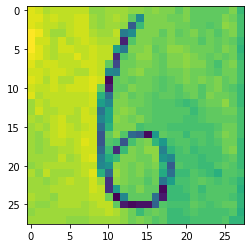


La imágen es un 6


In [ ]:
# Cargamos la imágen.
x = cargar_imagen('https://i.stack.imgur.com/CF1ze.jpg', cv2.INTER_AREA, 2)

# Clasificamos
HTy = clasificar_individual(clasificadores, x, True, True)

Vamos a probar otra...

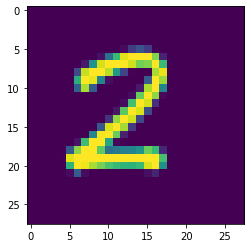


La imágen es un 2


In [ ]:
# Cargamos la imágen.
x = cargar_imagen('https://1001freedownloads.s3.amazonaws.com/vector/thumb/64380/0-9-Handwritten-6.png', cv2.INTER_AREA, 3)

# Clasificamos
HTy = clasificar_individual(clasificadores, x, True, True)

# Conclusiones.

La práctica ha molado muchisimo, porque hemos visto desde 0 como realizar un algoritmo y programa capaz de reconocer patrones en los datos de manera automatica con adaboost, en este caso numeros en fotos.

Personalmente me ha parecido muy interesante, y me ha gustado muchisimo, he aprendido además un montón de cosas durante el desarollo de la práctica.